In [85]:
!wget -O data.csv "https://rakamin-lms.s3.ap-southeast-1.amazonaws.com/vix-assets/idx-partners/loan_data_2007_2014.csv"

--2024-12-02 12:11:04--  https://rakamin-lms.s3.ap-southeast-1.amazonaws.com/vix-assets/idx-partners/loan_data_2007_2014.csv
Resolving rakamin-lms.s3.ap-southeast-1.amazonaws.com (rakamin-lms.s3.ap-southeast-1.amazonaws.com)... 3.5.148.176, 3.5.149.117, 52.219.125.59, ...
Connecting to rakamin-lms.s3.ap-southeast-1.amazonaws.com (rakamin-lms.s3.ap-southeast-1.amazonaws.com)|3.5.148.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240079969 (229M) [text/csv]
Saving to: ‘data.csv’

data.csv            100%[===================>] 228.96M  17.0MB/s    in 15s     

2024-12-02 12:11:20 (15.2 MB/s) - ‘data.csv’ saved [240079969/240079969]



In [ ]:
!pip install catboost

# Basic Libraries
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.decomposition import PCA

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Statistical Tests
from scipy.stats import chi2_contingency, f_oneway, ttest_ind, uniform, randint
from sklearn.feature_selection import mutual_info_classif

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score, f1_score, make_scorer, auc
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay

# Warnings
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [86]:
# Set display options to show all columns
pd.set_option("display.max_columns", None)  # No column limit
pd.set_option("display.expand_frame_repr", False)  # Prevent wrapping to new lines

# Read the file
df = pd.read_csv("data.csv")
print(df.head())

   Unnamed: 0       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment grade sub_grade                 emp_title emp_length home_ownership  annual_inc verification_status issue_d  loan_status pymnt_plan                                                url                                               desc         purpose                 title zip_code addr_state    dti  delinq_2yrs earliest_cr_line  inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  revol_bal  revol_util  total_acc initial_list_status  out_prncp  out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee last_pymnt_d  last_pymnt_amnt next_pymnt_d last_credit_pull_d  collections_12_mths_ex_med  mths_since_last_major_derog  policy_code application_type  annual_inc_joint  dti_joint  verification_status_joint  acc_now_delinq  tot_coll_amt  tot_cur_bal  open_acc_6m  open_il_6m  open

In [ ]:
df.shape

(466285, 75)

In [ ]:
pd.set_option("display.max_rows", None)

pd.Series(df.columns)

0                      Unnamed: 0
1                              id
2                       member_id
3                       loan_amnt
4                     funded_amnt
5                 funded_amnt_inv
6                            term
7                        int_rate
8                     installment
9                           grade
10                      sub_grade
11                      emp_title
12                     emp_length
13                 home_ownership
14                     annual_inc
15            verification_status
16                        issue_d
17                    loan_status
18                     pymnt_plan
19                            url
20                           desc
21                        purpose
22                          title
23                       zip_code
24                     addr_state
25                            dti
26                    delinq_2yrs
27               earliest_cr_line
28                 inq_last_6mths
29         mths_since_last_delinq
30         mths_since_last_record
31                       open_acc
32                        pub_rec
33                      revol_bal
34                     revol_util
35                      total_acc
36            initial_list_status
37                      out_prncp
38                  out_prncp_inv
39                    total_pymnt
40                total_pymnt_inv
41                total_rec_prncp
42                  total_rec_int
43             total_rec_late_fee
44                     recoveries
45        collection_recovery_fee
46                   last_pymnt_d
47                last_pymnt_amnt
48                   next_pymnt_d
49             last_credit_pull_d
50     collections_12_mths_ex_med
51    mths_since_last_major_derog
52                    policy_code
53               application_type
54               annual_inc_joint
55                      dti_joint
56      verification_status_joint
57                 acc_now_delinq
58                   tot_coll_amt
59                    tot_cur_bal
60                    open_acc_6m
61                     open_il_6m
62                    open_il_12m
63                    open_il_24m
64             mths_since_rcnt_il
65                   total_bal_il
66                        il_util
67                    open_rv_12m
68                    open_rv_24m
69                     max_bal_bc
70                       all_util
71               total_rev_hi_lim
72                         inq_fi
73                    total_cu_tl
74                   inq_last_12m
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [ ]:
df = df.drop(columns=["Unnamed: 0"])

In [ ]:
df.duplicated().sum()

0

In [ ]:
# Drop columns with 0 non-null values
df = df.dropna(axis=1, how='all')

# Display the resulting DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [ ]:
# Convert 'id' and 'member_id' to object (text)
df["id"] = df["id"].astype("object")
df["member_id"] = df["member_id"].astype("object")

In [ ]:
df.describe(include=np.number).T

count           mean            std      min           25%           50%           75%           max
loan_amnt                    466285.0   14317.277577    8286.509164   500.00   8000.000000  12000.000000   20000.00000  3.500000e+04
funded_amnt                  466285.0   14291.801044    8274.371300   500.00   8000.000000  12000.000000   20000.00000  3.500000e+04
funded_amnt_inv              466285.0   14222.329888    8297.637788     0.00   8000.000000  12000.000000   19950.00000  3.500000e+04
int_rate                     466285.0      13.829236       4.357587     5.42     10.990000     13.660000      16.49000  2.606000e+01
installment                  466285.0     432.061201     243.485550    15.67    256.690000    379.890000     566.58000  1.409990e+03
annual_inc                   466281.0   73277.381470   54963.568654  1896.00  45000.000000  63000.000000   88960.00000  7.500000e+06
dti                          466285.0      17.218758       7.851121     0.00     11.360000     16.870000      22.78000  3.999000e+01
delinq_2yrs                  466256.0       0.284678       0.797365     0.00      0.000000      0.000000       0.00000  2.900000e+01
inq_last_6mths               466256.0       0.804745       1.091598     0.00      0.000000      0.000000       1.00000  3.300000e+01
mths_since_last_delinq       215934.0      34.104430      21.778487     0.00     16.000000     31.000000      49.00000  1.880000e+02
mths_since_last_record        62638.0      74.306012      30.357653     0.00     53.000000     76.000000     102.00000  1.290000e+02
open_acc                     466256.0      11.187069       4.987526     0.00      8.000000     10.000000      14.00000  8.400000e+01
pub_rec                      466256.0       0.160564       0.510863     0.00      0.000000      0.000000       0.00000  6.300000e+01
revol_bal                    466285.0   16230.203487   20676.245152     0.00   6413.000000  11764.000000   20333.00000  2.568995e+06
revol_util                   465945.0      56.176947      23.732628     0.00     39.200000     57.600000      74.70000  8.923000e+02
total_acc                    466256.0      25.064430      11.600141     1.00     17.000000     23.000000      32.00000  1.560000e+02
out_prncp                    466285.0    4410.062342    6355.078769     0.00      0.000000    441.470000    7341.65000  3.216038e+04
out_prncp_inv                466285.0    4408.452258    6353.198001     0.00      0.000000    441.380000    7338.39000  3.216038e+04
total_pymnt                  466285.0   11540.686220    8265.627112     0.00   5552.125349   9419.250943   15308.15846  5.777758e+04
total_pymnt_inv              466285.0   11469.892747    8254.157579     0.00   5499.250000   9355.430000   15231.31000  5.777758e+04
total_rec_prncp              466285.0    8866.014657    7031.687997     0.00   3708.560000   6817.760000   12000.00000  3.500003e+04
total_rec_int                466285.0    2588.677225    2483.809661     0.00    957.280000   1818.880000    3304.53000  2.420562e+04
total_rec_late_fee           466285.0       0.650129       5.265730     0.00      0.000000      0.000000       0.00000  3.586800e+02
recoveries                   466285.0      85.344211     552.216084     0.00      0.000000      0.000000       0.00000  3.352027e+04
collection_recovery_fee      466285.0       8.961534      85.491437     0.00      0.000000      0.000000       0.00000  7.002190e+03
last_pymnt_amnt              466285.0    3123.913796    5554.737393     0.00    312.620000    545.960000    3187.51000  3.623444e+04
collections_12_mths_ex_med   466140.0       0.009085       0.108648     0.00      0.000000      0.000000       0.00000  2.000000e+01
mths_since_last_major_derog   98974.0      42.852547      21.662591     0.00     26.000000     42.000000      59.00000  1.880000e+02
policy_code                  466285.0       1.000000       0.000000     1.00      1.000000      1.000000       1.00000  1.000000e+00
acc_now_delinq               466256.0     

In [ ]:
df.describe(include='object').T

count  unique                                                top    freq
id                   466285  466285                                            1077501       1
member_id            466285  466285                                            1296599       1
term                 466285       2                                          36 months  337953
grade                466285       7                                                  B  136929
sub_grade            466285      35                                                 B3   31686
emp_title            438697  205475                                            Teacher    5399
emp_length           445277      11                                          10+ years  150049
home_ownership       466285       6                                           MORTGAGE  235875
verification_status  466285       3                                           Verified  168055
issue_d              466285      91                                             Oct-14   38782
loan_status          466285       9                                            Current  224226
pymnt_plan           466285       2                                                  n  466276
url                  466285  466285  https://www.lendingclub.com/browse/loanDetail....       1
desc                 125981  124435                                                        234
purpose              466285      14                                 debt_consolidation  274195
title                466264   63098                                 Debt consolidation  164075
zip_code             466285     888                                              945xx    5304
addr_state           466285      50                                                 CA   71450
earliest_cr_line     466256     664                                             Oct-00    3674
initial_list_status  466285       2                                                  f  303005
last_pymnt_d         465909      98                                             Jan-16  179620
next_pymnt_d         239071     100                                             Feb-16  208393
last_credit_pull_d   466243     103                                             Jan-16  327699
application_type     466285       1                                         INDIVIDUAL  466285

In [ ]:
# Format data ini tidak teragregasi, levelnya adalah level transaksi atau member. Karena keduanya unik, maka satu orang hanya memiliki satu pinjaman.

In [ ]:
# X adalah semua kolom kecuali loan_status, y adalah loan_status

In [ ]:
df['loan_status'].value_counts()

loan_status
Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64

In [ ]:
# Dataset cukup untuk melakukan pemodelan

# Data Cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  object 
 1   member_id                    466285 non-null  object 
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [ ]:
print('Missing values status:', df.isnull().values.any())
missing_percentage = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
missing_percentage['Percentage'] = (missing_percentage['Total Null Values']/df.shape[0])*100
missing_percentage["Data Type"] = [df[col].dtype for col in df.columns]
missing_percentage.sort_values(by=["Total Null Values", "Percentage"], ascending=False, inplace=True)
missing_percentage.style.background_gradient(cmap='Blues')

Missing values status: True


In [ ]:
# Deleting ............... columns

df = df.drop(['desc',	'mths_since_last_record',	'mths_since_last_major_derog'], axis=1)

In [ ]:
# Deleting NA values where the percentage is less than 0.5%
df = df.dropna(subset=['last_pymnt_d', 'revol_util', 'collections_12_mths_ex_med', 'last_credit_pull_d', 'total_acc', 'acc_now_delinq', 'inq_last_6mths', 'earliest_cr_line', 'delinq_2yrs', 'open_acc', 'pub_rec', 'title', 'annual_inc'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 465401 entries, 0 to 466284
Data columns (total 54 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          465401 non-null  object 
 1   member_id                   465401 non-null  object 
 2   loan_amnt                   465401 non-null  int64  
 3   funded_amnt                 465401 non-null  int64  
 4   funded_amnt_inv             465401 non-null  float64
 5   term                        465401 non-null  object 
 6   int_rate                    465401 non-null  float64
 7   installment                 465401 non-null  float64
 8   grade                       465401 non-null  object 
 9   sub_grade                   465401 non-null  object 
 10  emp_title                   437894 non-null  object 
 11  emp_length                  444432 non-null  object 
 12  home_ownership              465401 non-null  object 
 13  annual_inc         

In [ ]:
df.duplicated().value_counts()

False    465401
Name: count, dtype: int64

In [ ]:
df[df.duplicated(keep=False)].sort_values(by=list(df.columns.values)).head()

Empty DataFrame
Columns: [id, member_id, loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, pymnt_plan, url, purpose, title, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, mths_since_last_delinq, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d, last_credit_pull_d, collections_12_mths_ex_med, policy_code, application_type, acc_now_delinq, tot_coll_amt, tot_cur_bal, total_rev_hi_lim]
Index: []

# Feature Transformation

In [ ]:
df.describe(include=['object']).T

count  unique                                                top    freq
id                   465401  465401                                            1077501       1
member_id            465401  465401                                            1296599       1
term                 465401       2                                          36 months  337249
grade                465401       7                                                  B  136769
sub_grade            465401      35                                                 B3   31654
emp_title            437894  205072                                            Teacher    5392
emp_length           444432      11                                          10+ years  149844
home_ownership       465401       6                                           MORTGAGE  235538
verification_status  465401       3                                           Verified  167791
issue_d              465401      89                                             Oct-14   38724
loan_status          465401       9                                            Current  224096
pymnt_plan           465401       2                                                  n  465392
url                  465401  465401  https://www.lendingclub.com/browse/loanDetail....       1
purpose              465401      14                                 debt_consolidation  273815
title                465401   62878                                 Debt consolidation  163888
zip_code             465401     888                                              945xx    5298
addr_state           465401      50                                                 CA   71320
earliest_cr_line     465401     664                                             Oct-00    3667
initial_list_status  465401       2                                                  f  302324
last_pymnt_d         465401      98                                             Jan-16  179515
next_pymnt_d         238822     100                                             Feb-16  208274
last_credit_pull_d   465401     100                                             Jan-16  327417
application_type     465401       1                                         INDIVIDUAL  465401

In [ ]:
# Columns to exclude
exclude_columns = ['id', 'member_id', 'emp_title',  'url', 'title', 'zip_code', 'earliest_cr_line',  'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'issue_d']

# Select all columns except the excluded ones
selected_columns = df.loc[:, ~df.columns.isin(exclude_columns)]

In [ ]:
cat_cols = selected_columns.select_dtypes(include=['object']).columns.tolist()

# Create an empty dictionary to store value counts and percentages for each categorical column
categorical_value_counts = {}

# Iterate through categorical columns and store value counts and percentages in the dictionary
for column in cat_cols:
    # Calculate value counts
    value_counts = selected_columns[column].value_counts()

    # Calculate percentages
    percentages = (value_counts / len(selected_columns)) * 100

    # Combine value counts and percentages into a DataFrame
    categorical_value_counts[column] = pd.DataFrame({
        "Value Counts": value_counts,
        "Percentage": percentages
    })

# Display the value counts and percentages for each categorical column
for column, value_counts_df in categorical_value_counts.items():
    display(value_counts_df.style.set_caption(f"Value Counts and Percentages for {column}"))

In [ ]:
df['zip_code'].value_counts()/len(df)*100

zip_code
945xx    1.138373
112xx    1.093466
750xx    1.076061
606xx    1.008378
100xx    0.938760
300xx    0.882680
900xx    0.872581
070xx    0.871507
331xx    0.853028
770xx    0.769659
917xx    0.761709
891xx    0.715297
330xx    0.697463
104xx    0.695099
117xx    0.692951
921xx    0.674902
926xx    0.643101
852xx    0.628061
913xx    0.613449
113xx    0.575847
925xx    0.566823
080xx    0.536097
334xx    0.535667
021xx    0.535452
941xx    0.516759
601xx    0.510098
604xx    0.506875
980xx    0.501933
600xx    0.498280
956xx    0.497206
481xx    0.496561
928xx    0.492479
920xx    0.489041
201xx    0.470132
853xx    0.466694
951xx    0.460893
301xx    0.457240
760xx    0.449720
902xx    0.448645
802xx    0.447356
207xx    0.441770
773xx    0.438976
850xx    0.436398
088xx    0.431886
923xx    0.430811
774xx    0.419638
940xx    0.406746
114xx    0.404597
212xx    0.397507
480xx    0.394928
554xx    0.388052
333xx    0.386763
800xx    0.386548
275xx    0.382896
553xx    0.375375
958xx    0.375160
840xx    0.374516
303xx    0.371937
953xx    0.371722
782xx    0.370648
752xx    0.370433
787xx    0.369144
605xx    0.367855
967xx    0.364202
328xx    0.358401
327xx    0.354533
890xx    0.347872
786xx    0.345079
191xx    0.341426
950xx    0.333906
981xx    0.333691
775xx    0.332831
190xx    0.332402
064xx    0.327460
441xx    0.325955
483xx    0.324237
302xx    0.316716
282xx    0.315427
972xx    0.311774
430xx    0.308336
801xx    0.306832
761xx    0.306188
200xx    0.305758
906xx    0.302535
060xx    0.301031
028xx    0.297163
210xx    0.296089
322xx    0.289643
907xx    0.286205
970xx    0.284486
982xx    0.281263
115xx    0.281048
208xx    0.280403
922xx    0.279544
335xx    0.279329
337xx    0.278684
930xx    0.277180
751xx    0.270734
919xx    0.269445
152xx    0.267511
105xx    0.267082
551xx    0.263644
336xx    0.261280
857xx    0.255908
018xx    0.254834
076xx    0.253760
103xx    0.251396
432xx    0.250966
799xx    0.250322
296xx    0.250107
983xx    0.249677
440xx    0.245810
452xx    0.244735
631xx    0.241082
077xx    0.238719
347xx    0.237645
109xx    0.234851
294xx    0.230124
871xx    0.227975
342xx    0.227116
462xx    0.225182
550xx    0.224967
370xx    0.224538
283xx    0.224108
346xx    0.219596
142xx    0.219381
339xx    0.218736
211xx    0.217662
908xx    0.215728
280xx    0.212720
640xx    0.211645
221xx    0.210356
217xx    0.210141
935xx    0.208637
762xx    0.207993
329xx    0.206274
220xx    0.206274
809xx    0.205629
234xx    0.203695
325xx    0.201976
450xx    0.199828
986xx    0.199828
074xx    0.198753
338xx    0.198538
785xx    0.198109
630xx    0.197894
180xx    0.195745
276xx    0.192092
463xx    0.191663
805xx    0.190373
532xx    0.189514
641xx    0.189514
402xx    0.189299
946xx    0.188440
305xx    0.188010
232xx    0.186291
957xx    0.186291
973xx    0.184787
223xx    0.182853
194xx    0.182853
442xx    0.182208
660xx    0.181564
027xx    0.180275
740xx    0.179845
765xx    0.178771
531xx    0.177481
410xx    0.177052
023xx    0.176622
068xx    0.176192
320xx    0.175762
125xx    0.174258
932xx    0.174043
019xx    0.173184
111xx    0.172969
730xx    0.172754
130xx    0.171680
010xx    0.171465
954xx    0.170820
933xx    0.170176
140xx    0.169746
700xx    0.169316
078xx    0.167597
841xx    0.167168
968xx    0.167168
633xx    0.166523
146xx    0.166093
349xx    0.163730
705xx    0.163085
959xx    0.162870
731xx    0.162226
662xx    0.161151
530xx    0.161151
087xx    0.160722
949xx    0.160292
073xx    0.156639
281xx    0.154705
030xx    0.154490
015xx    0.154490
934xx    0.154490
206xx    0.154276
431xx    0.153846
974xx    0.153846
488xx    0.152771
067xx    0.151267
985xx    0.149548
272xx    0.148689
927xx    0.148689
490xx    0.148474
170xx    0.147615
482xx    0.147615
952xx    0.146540
295xx    0.144821
461xx    0.144606
120xx    0.143747
371xx    0.143102
321xx    0.142243
029xx    0.142028
352xx    0.141813
460xx    0.141383
310xx    0.141383
150xx    0.139665
937xx    0.13

In [ ]:
# Convert columns to datetime format assuming the 1st of the month
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y')
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%y')
df['next_pymnt_d'] = pd.to_datetime(df['next_pymnt_d'], format='%b-%y')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%y')

In [ ]:
df['emp_length'] = df['emp_length'].replace({
    '10+ years': 10,
    '9 years': 9,
    '8 years': 8,
    '7 years': 7,
    '6 years': 6,
    '5 years': 5,
    '4 years': 4,
    '3 years': 3,
    '2 years': 2,
    '1 year': 1,
    "< 1 year": 0
})


In [ ]:
df['home_ownership'] = df['home_ownership'].replace({
    'OTHER': 'OTHER',
    'NONE': 'OTHER',
    'ANY': 'OTHER',
    'OWN': 'OWN',
    'MORTGAGE': 'MORTGAGE',
    'RENT': 'RENT'
})

In [ ]:
df['policy_code'].value_counts()

policy_code
1    465401
Name: count, dtype: int64

In [ ]:
df['loan_status'] = df['loan_status'].replace({
    'Fully Paid': 1,
    'Charged Off': 0,
    'Current': 1,
    'In Grace Period': 1,
    'Late (31-120 days)': 0,
    'Late (16-30 days)': 0,
    'Default': 0})

In [ ]:
df = df[df['loan_status'].isin([0, 1])]

In [ ]:
df['purpose'] = df['purpose'].replace({
    'wedding': 'other',
    'medical': 'other',
    'moving': 'other',
    'vacation': 'other',
    'house': 'other',
    'renewable_energy': 'other',
    'educational': 'other'})

df['purpose'].value_counts()

purpose
debt_consolidation    272743
credit_card           103734
other                  38233
home_improvement       26250
major_purchase          9669
small_business          6818
car                     5316
Name: count, dtype: int64

In [ ]:
df['sub_grade'] = df['sub_grade'].replace({
    'F1': 'High Risk',
    'F2': 'High Risk',
    'F3': 'High Risk',
    'F4': 'High Risk',
    'F5': 'High Risk',
    'G1': 'High Risk',
    'G2': 'High Risk',
    'G3': 'High Risk',
    'G4': 'High Risk',
    'G5': 'High Risk',
})

In [ ]:
df['addr_state'] = df['addr_state'].replace({
    'KY': 'other',
    'KS': 'other',
    'OK': 'other',
    'AR': 'other',
    'UT': 'other',
    'NM': 'other',
    'HI': 'other',
    'WV': 'other',
    'NH': 'other',
    'RI': 'other',
    'DC': 'other',
    'MT': 'other',
    'DE': 'other',
    'AK': 'other',
    'MS': 'other',
    'WY': 'other',
    'SD': 'other',
    'VT': 'other',
    'IA': 'other',
    'ID': 'other',
    'NE': 'other',
    'ME': 'other'})

In [ ]:
df['installment'].value_counts().shape

(55046,)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 462763 entries, 0 to 466284
Data columns (total 54 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   id                          462763 non-null  object        
 1   member_id                   462763 non-null  object        
 2   loan_amnt                   462763 non-null  int64         
 3   funded_amnt                 462763 non-null  int64         
 4   funded_amnt_inv             462763 non-null  float64       
 5   term                        462763 non-null  object        
 6   int_rate                    462763 non-null  float64       
 7   installment                 462763 non-null  float64       
 8   grade                       462763 non-null  object        
 9   sub_grade                   462763 non-null  object        
 10  emp_title                   435398 non-null  object        
 11  emp_length                  441828 non-null 

In [ ]:
numerical_features = df.select_dtypes(include=['number'])  # Select numerical columns
nunique_counts = numerical_features.nunique()  # Calculate unique value counts

# Display the results
print(nunique_counts)

loan_amnt                       1347
funded_amnt                     1349
funded_amnt_inv                 8814
int_rate                         484
installment                    55046
emp_length                        11
annual_inc                     31720
dti                             3997
delinq_2yrs                       24
inq_last_6mths                     9
mths_since_last_delinq           145
open_acc                          61
pub_rec                           26
revol_bal                      57742
revol_util                      1261
total_acc                        111
out_prncp                     135603
out_prncp_inv                 141126
total_pymnt                   348663
total_pymnt_inv               344814
total_rec_prncp               171921
total_rec_int                 268816
total_rec_late_fee              5491
recoveries                     22056
collection_recovery_fee        19896
last_pymnt_amnt               196851
collections_12_mths_ex_med         9
p

In [ ]:
num_cols = ['inq_last_6mths', 'collections_12_mths_ex_med', 'acc_now_delinq', 'delinq_2yrs', 'pub_rec']

# Create an empty dictionary to store value counts and percentages for each categorical column
numerical_value_counts = {}

# Iterate through categorical columns and store value counts and percentages in the dictionary
for column in num_cols:
    # Calculate value counts
    value_counts = df[column].value_counts()

    # Calculate percentages
    percentages = (value_counts / len(df)) * 100

    # Combine value counts and percentages into a DataFrame
    numerical_value_counts[column] = pd.DataFrame({
        "Value Counts": value_counts,
        "Percentage": percentages
    })

# Display the value counts and percentages for each categorical column
for column, value_counts_df in numerical_value_counts.items():
    display(value_counts_df.style.set_caption(f"Value Counts and Percentages for {column}"))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 462763 entries, 0 to 466284
Data columns (total 54 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   id                          462763 non-null  object        
 1   member_id                   462763 non-null  object        
 2   loan_amnt                   462763 non-null  int64         
 3   funded_amnt                 462763 non-null  int64         
 4   funded_amnt_inv             462763 non-null  float64       
 5   term                        462763 non-null  object        
 6   int_rate                    462763 non-null  float64       
 7   installment                 462763 non-null  float64       
 8   grade                       462763 non-null  object        
 9   sub_grade                   462763 non-null  object        
 10  emp_title                   435398 non-null  object        
 11  emp_length                  441828 non-null 

# DROOP BUAT FEATURE ENGINEERING & ALASANNYAAAA


In [ ]:
df['issue_yr'] = df['issue_d'].dt.year
df['issue_mon'] = df['issue_d'].dt.month

df['last_pymnt_yr'] = df['last_pymnt_d'].dt.year
df['last_pymnt_mon'] = df['last_pymnt_d'].dt.month

In [ ]:
df = df.drop(['next_pymnt_d', 'last_credit_pull_d', 'pymnt_plan', 'application_type', 'zip_code', 'policy_code', 'id', 'member_id', 'emp_title',  'url', 'title'], axis=1)

In [ ]:
# Current date for reference (assuming today for calculations)
current_date = datetime.now()

# 1. Loan-to-Income Ratio
df['loan_to_income_ratio'] = df['loan_amnt'] / df['annual_inc']

# 2. Payment Progress
df['payment_progress'] = df['total_pymnt'] / df['funded_amnt']

# 3. Time-Based Features
# Loan Age (in months)
df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')  # Convert to datetime
df['loan_age_months'] = ((current_date - df['issue_d']).dt.days / 30).fillna(0)

# Time Since Last Payment (in months)
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], errors='coerce')
df['time_since_last_payment_months'] = ((current_date - df['last_pymnt_d']).dt.days / 30).fillna(np.nan)

# 4. Derived Credit History Length
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], errors='coerce')
df['credit_history_length_years'] = ((df['issue_d'] - df['earliest_cr_line']).dt.days / 365).fillna(0)

# 5. High Credit Utilization Flags
df['high_credit_util_flag'] = (df['revol_util'] > 80).astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 462763 entries, 0 to 466284
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   loan_amnt                       462763 non-null  int64         
 1   funded_amnt                     462763 non-null  int64         
 2   funded_amnt_inv                 462763 non-null  float64       
 3   term                            462763 non-null  object        
 4   int_rate                        462763 non-null  float64       
 5   installment                     462763 non-null  float64       
 6   grade                           462763 non-null  object        
 7   sub_grade                       462763 non-null  object        
 8   emp_length                      441828 non-null  float64       
 9   home_ownership                  462763 non-null  object        
 10  annual_inc                      462763 non-null  float64     

# Exploratory Data Analysis

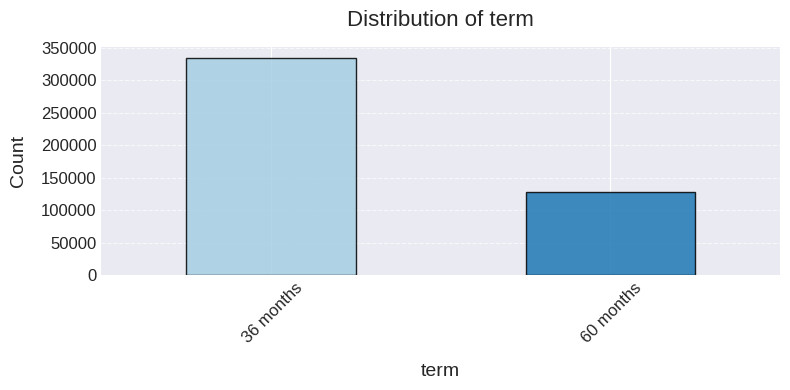

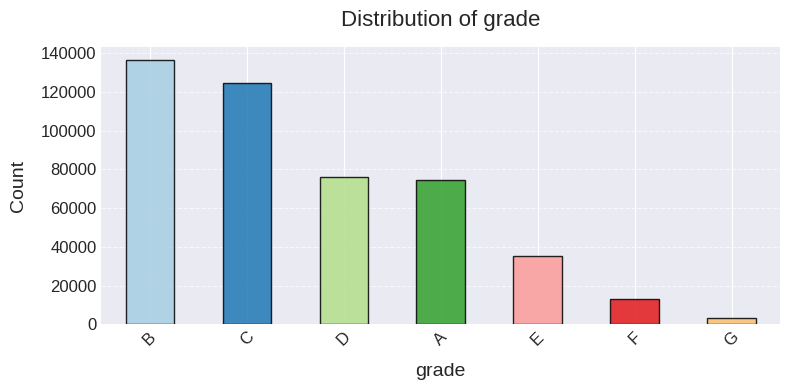

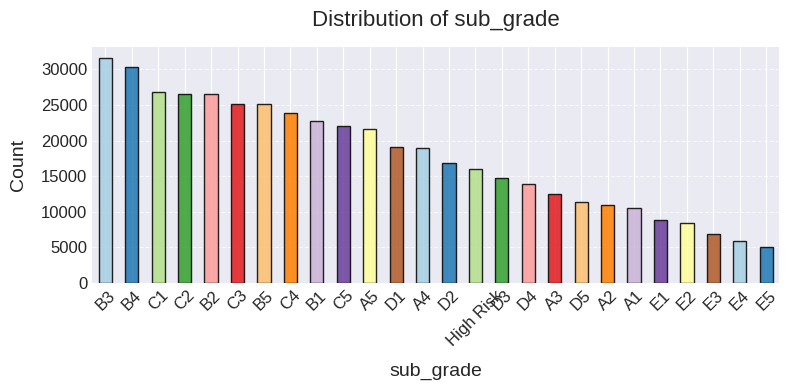

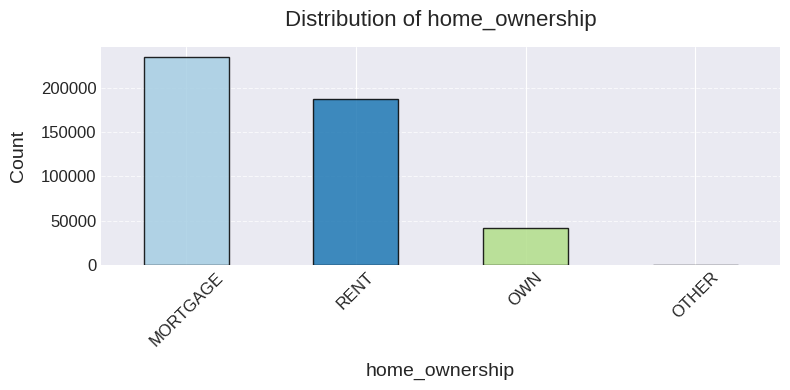

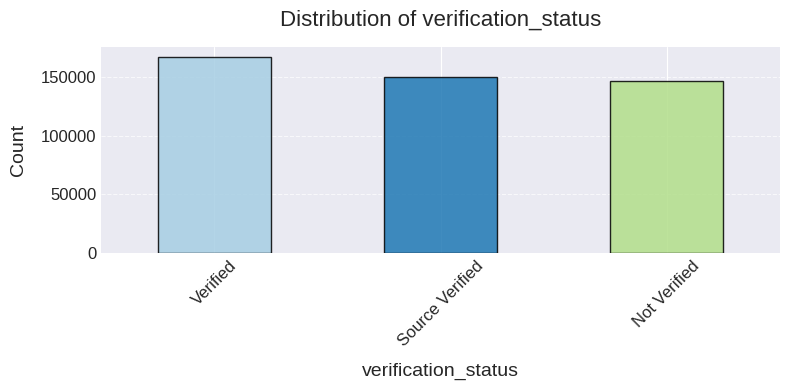

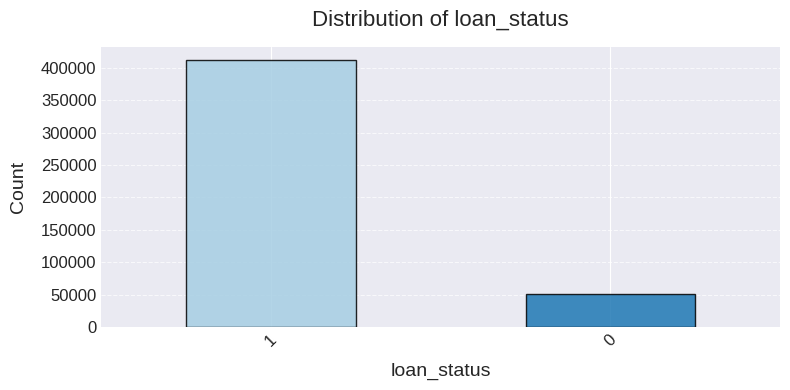

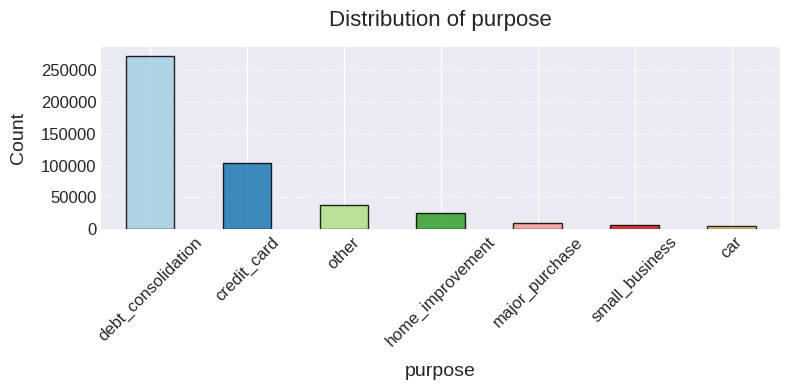

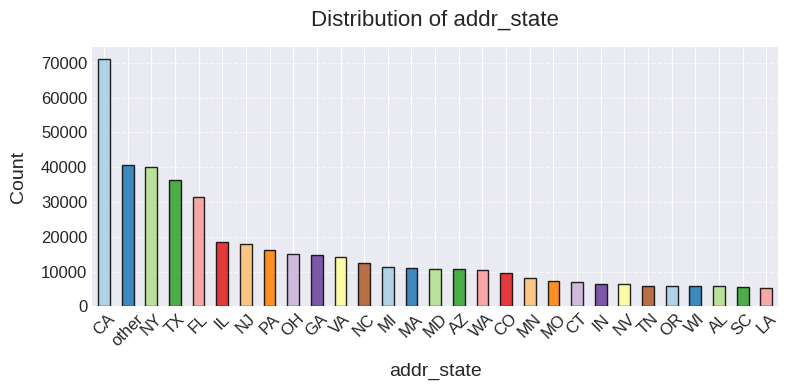

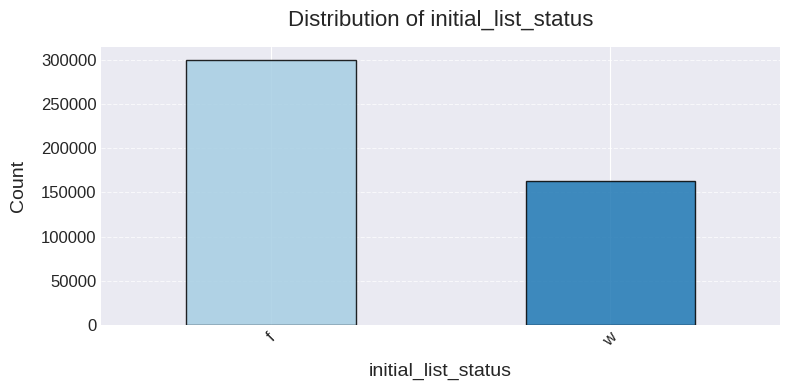

In [ ]:
# Identifying the categorical variables
cat_var = df.select_dtypes(include=["object"]).columns

# Plotting bar chart for each categorical variable
plt.style.use("seaborn-v0_8-darkgrid")  # Use a clean style
palette = plt.cm.Paired.colors  # Choose a color palette

for i, column in enumerate(cat_var, start=1):
    # Create figure for each variable
    plt.figure(figsize=(8, 4))  # Set figure size

    # Bar plot
    df[column].value_counts().plot(
        kind="bar",
        color=palette,
        edgecolor="black",
        alpha=0.85,
    )

    # Add labels and title
    plt.xlabel(column, fontsize=14, labelpad=10)
    plt.ylabel("Count", fontsize=14, labelpad=10)
    plt.title(f"Distribution of {column}", fontsize=16, pad=15)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    # Add gridlines
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show plot
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

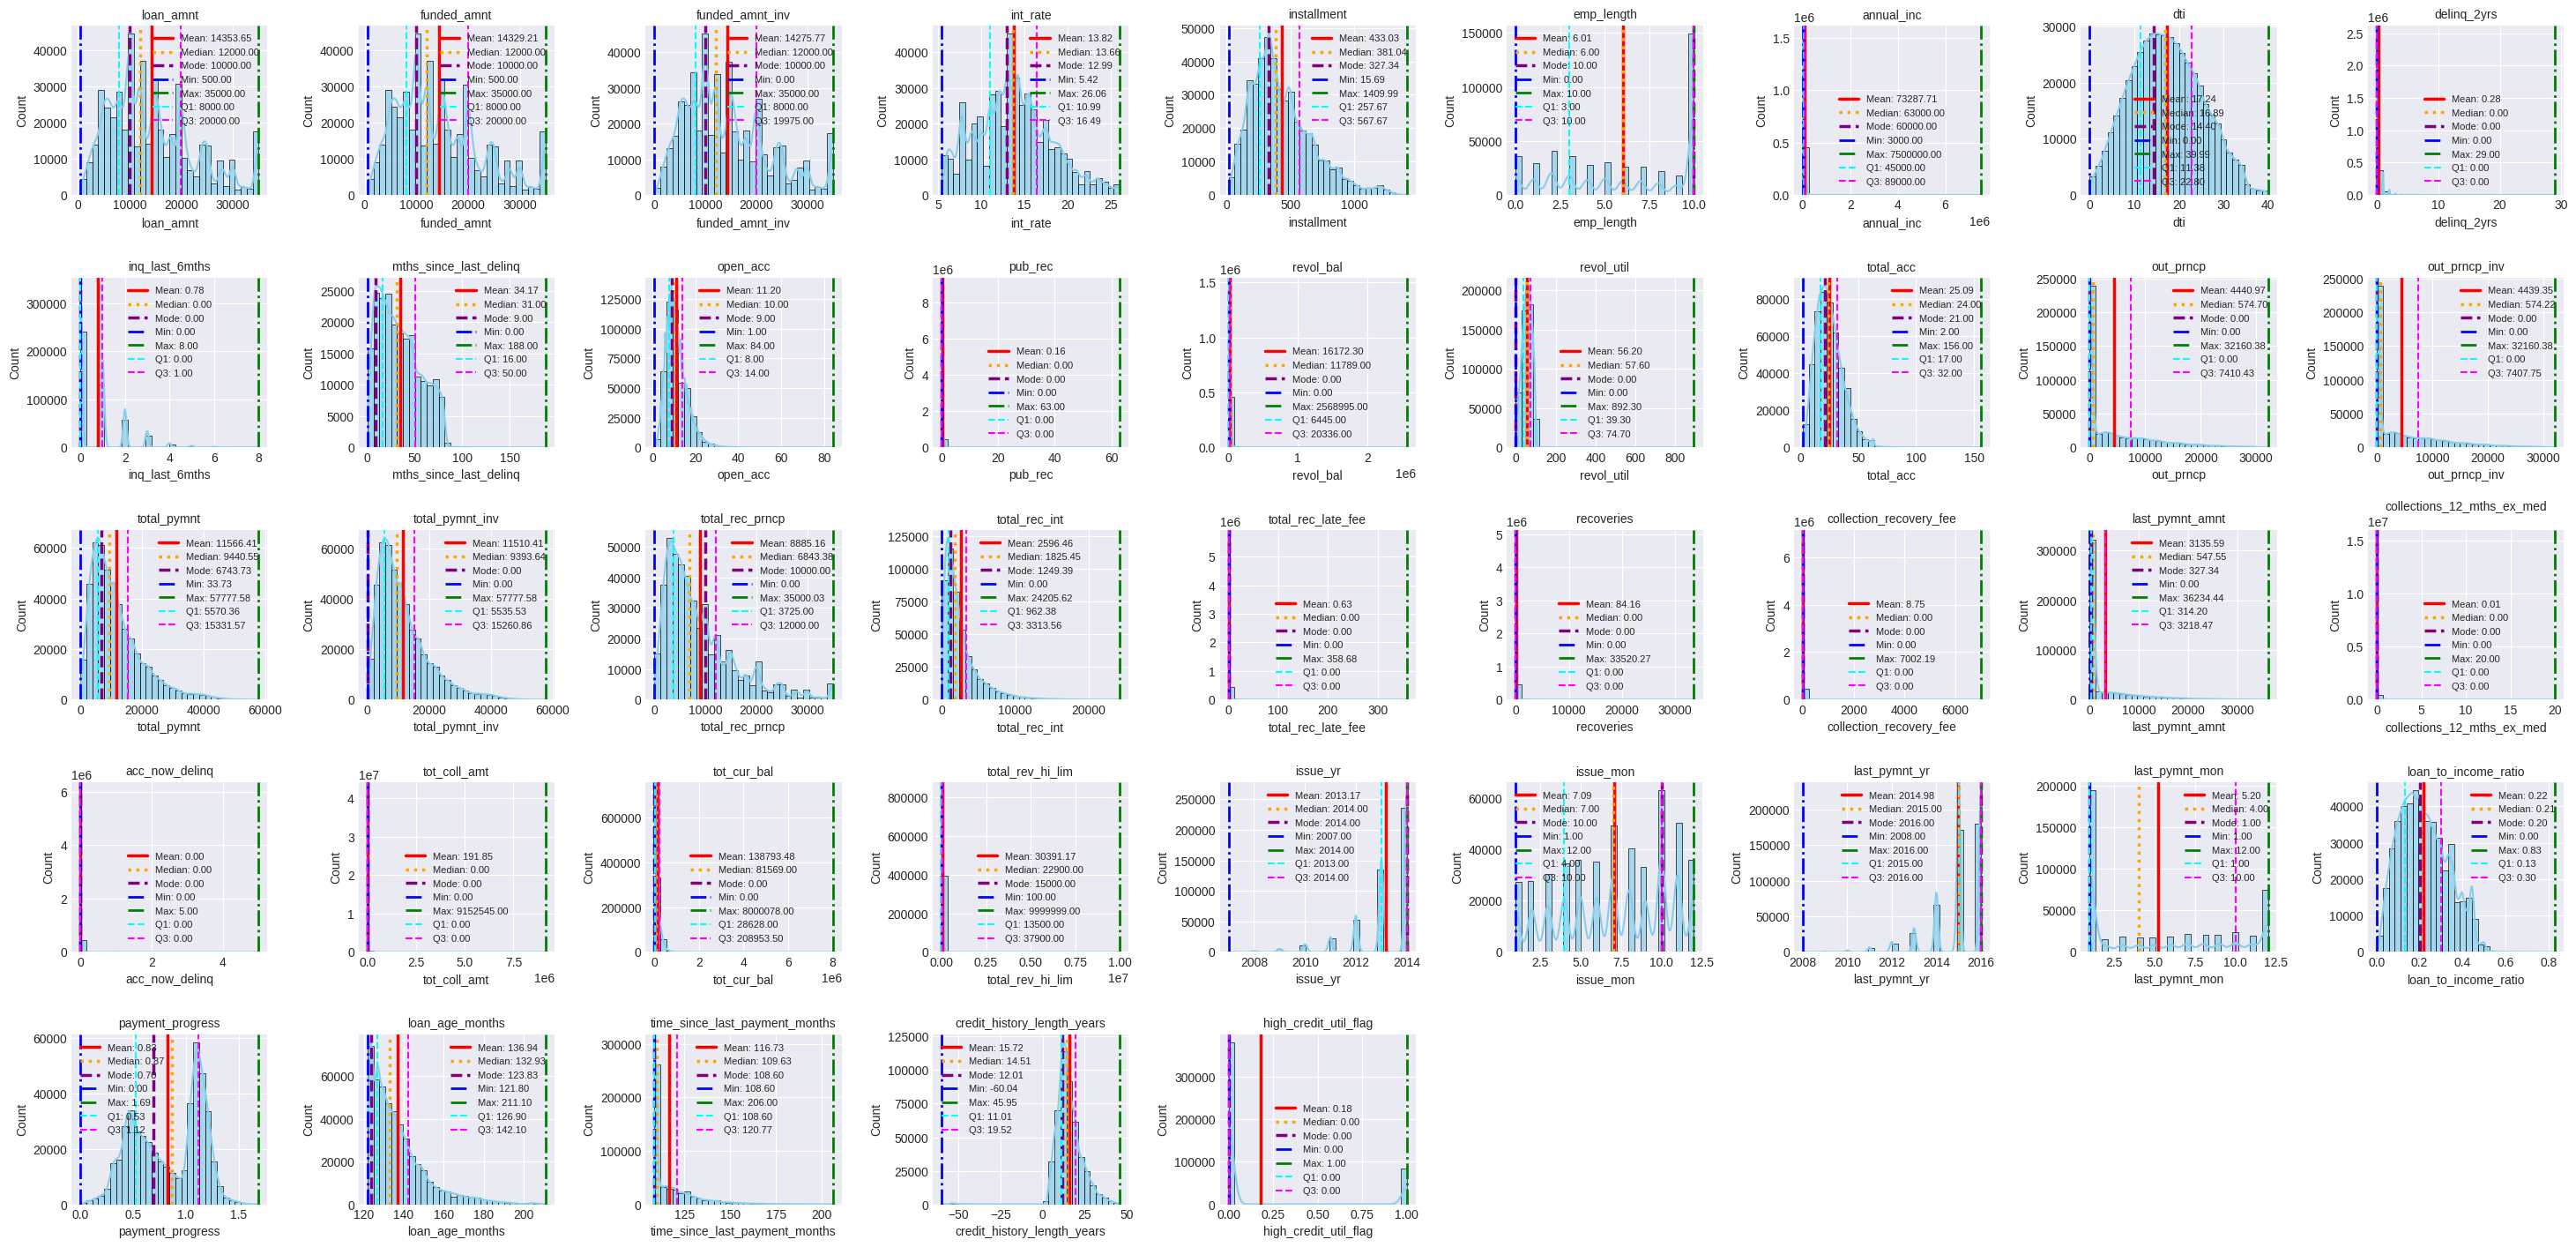

In [ ]:
# Select numerical variables
num_var = df.select_dtypes(include=np.number).columns

# Define the number of rows and columns for subplots
rows, cols = 5, 9
fig, axes = plt.subplots(rows, cols, figsize=(30, 15))  # Adjust figsize for better visualization
fig.tight_layout(pad=5.0)  # Adjust spacing between subplots

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each histogram
for idx, column in enumerate(num_var):
    # Compute statistics
    average = df[column].mean()
    median = df[column].median()
    mode = df[column].mode()
    min_val = df[column].min()
    max_val = df[column].max()
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)

    # Plot histogram on the corresponding subplot
    sns.histplot(df[column], kde=True, bins=30, color="skyblue", edgecolor="black", alpha=0.7, ax=axes[idx])

    # Add vertical lines for statistics
    axes[idx].axvline(average, color="red", linestyle="solid", linewidth=2.5, label=f'Mean: {average:.2f}')
    axes[idx].axvline(median, color="orange", linestyle="dotted", linewidth=2.5, label=f'Median: {median:.2f}')
    axes[idx].axvline(mode[0], color="purple", linestyle="dashed", linewidth=2.5, label=f'Mode: {mode[0]:.2f}')
    axes[idx].axvline(min_val, color="blue", linestyle="dashdot", linewidth=2, label=f'Min: {min_val:.2f}')
    axes[idx].axvline(max_val, color="green", linestyle="dashdot", linewidth=2, label=f'Max: {max_val:.2f}')
    axes[idx].axvline(q1, color="cyan", linestyle="dashed", linewidth=1.5, label=f'Q1: {q1:.2f}')
    axes[idx].axvline(q3, color="magenta", linestyle="dashed", linewidth=1.5, label=f'Q3: {q3:.2f}')

    # Add title and legend to each subplot
    axes[idx].set_title(column, fontsize=10)
    axes[idx].legend(fontsize=8)

# Hide unused subplots if there are any
for i in range(len(num_var), len(axes)):
    fig.delaxes(axes[i])

# Show the combined plot
plt.show()


Skipping column 'loan_status' due to error: index must be a MultiIndex to unstack, <class 'pandas.core.indexes.base.Index'> was passed


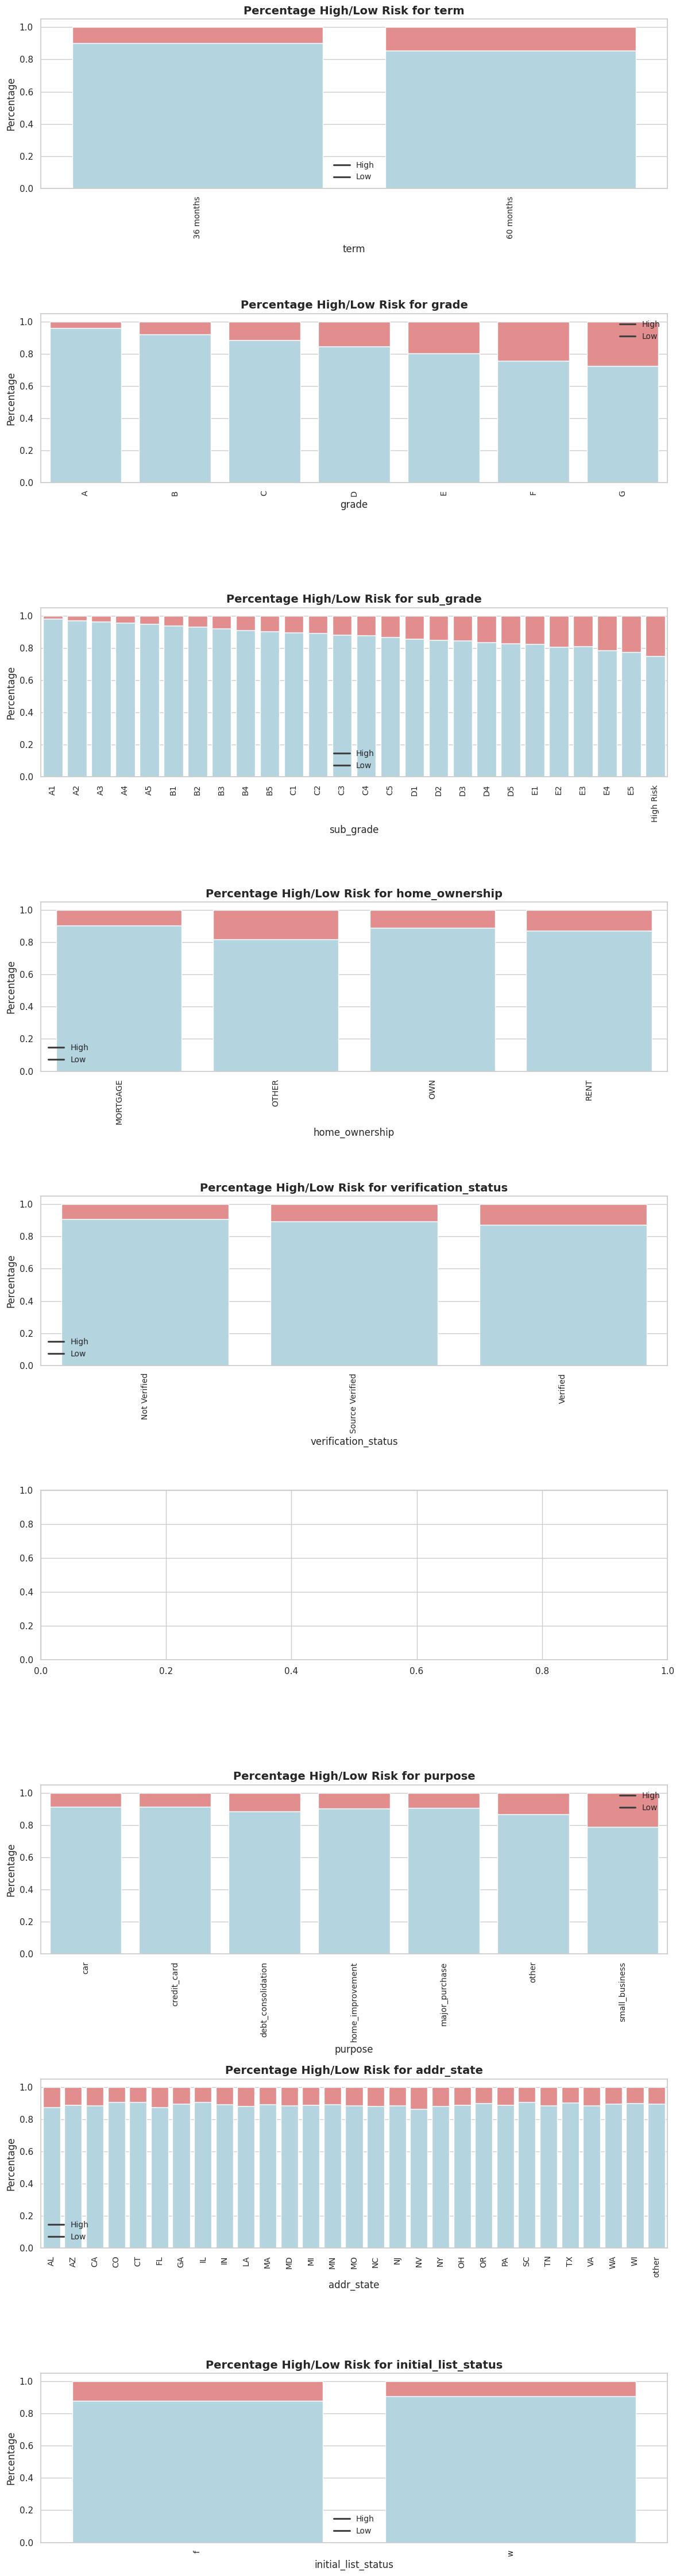

In [ ]:
# Categorical columns to visualize
categorical_columns = df.select_dtypes(include=['object']).columns

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Create subplots: 1 column (1 graph per row)
num_plots = len(categorical_columns)
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(12, 5 * num_plots))
axes = axes.flatten() if num_plots > 1 else [axes]  # Ensure axes is always a list

# Iterate through each categorical column
for i, column in enumerate(categorical_columns):
    ax = axes[i]

    try:
        # Calculate normalized value counts grouped by loan_status
        grouped_data = (
            df.groupby(column)['loan_status']
            .value_counts(normalize=True)
            .unstack('loan_status', fill_value=0)  # Fill missing values with 0
        )

        # Ensure columns are ordered correctly
        if grouped_data.columns.size == 2:  # Only reorder if exactly two categories exist
            grouped_data = grouped_data.sort_index(axis=1)

        # Plot stacked bar charts
        sns.barplot(
            x=grouped_data.index,
            y=grouped_data.iloc[:, 1],  # Second column as 'Low'
            color='lightblue',
            label='Low',
            ax=ax
        )
        sns.barplot(
            x=grouped_data.index,
            y=grouped_data.iloc[:, 0],  # First column as 'High'
            color='lightcoral',
            label='High',
            bottom=grouped_data.iloc[:, 1],  # Stack on top of 'Low'
            ax=ax
        )

        # Set titles and labels
        ax.set_title(f'Percentage High/Low Risk for {column}', fontsize=14, fontweight='bold')
        ax.set_ylabel('Percentage', fontsize=12)
        ax.set_xlabel(column, fontsize=12)
        ax.legend(labels=('High', 'Low'), fontsize=10)

        # Adjust x-axis ticks for readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)

    except Exception as e:
        print(f"Skipping column '{column}' due to error: {e}")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


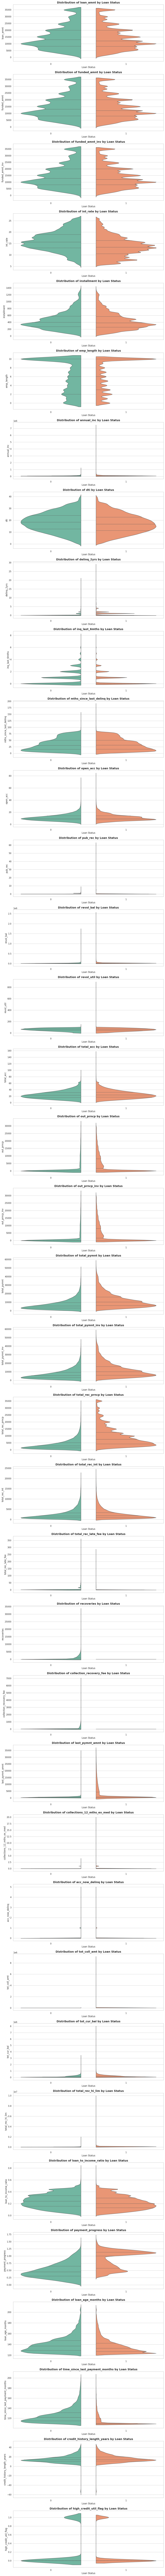

In [ ]:
# List of numerical columns to visualize
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Create subplots: 1 column (1 graph per row)
num_plots = len(numerical_columns)
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(12, 5 * num_plots))
axes = axes.flatten() if num_plots > 1 else [axes]  # Ensure axes is always a list

# Iterate through each numerical column
for i, column in enumerate(numerical_columns):
    ax = axes[i]

    # Create the violin plot for each numerical column, grouped by 'loan_status'
    sns.violinplot(
        x='loan_status',  # hue or category for splitting
        y=column,  # Numerical variable
        data=df,
        ax=ax,
        palette='Set2',  # Adjust color palette if needed
        split=True,  # Split the violins by 'loan_status'
        inner="quart",  # Show the quartiles inside the violins
    )

    # Set titles and labels
    ax.set_title(f'Distribution of {column} by Loan Status', fontsize=14, fontweight='bold')
    ax.set_xlabel('Loan Status', fontsize=12)
    ax.set_ylabel(column, fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


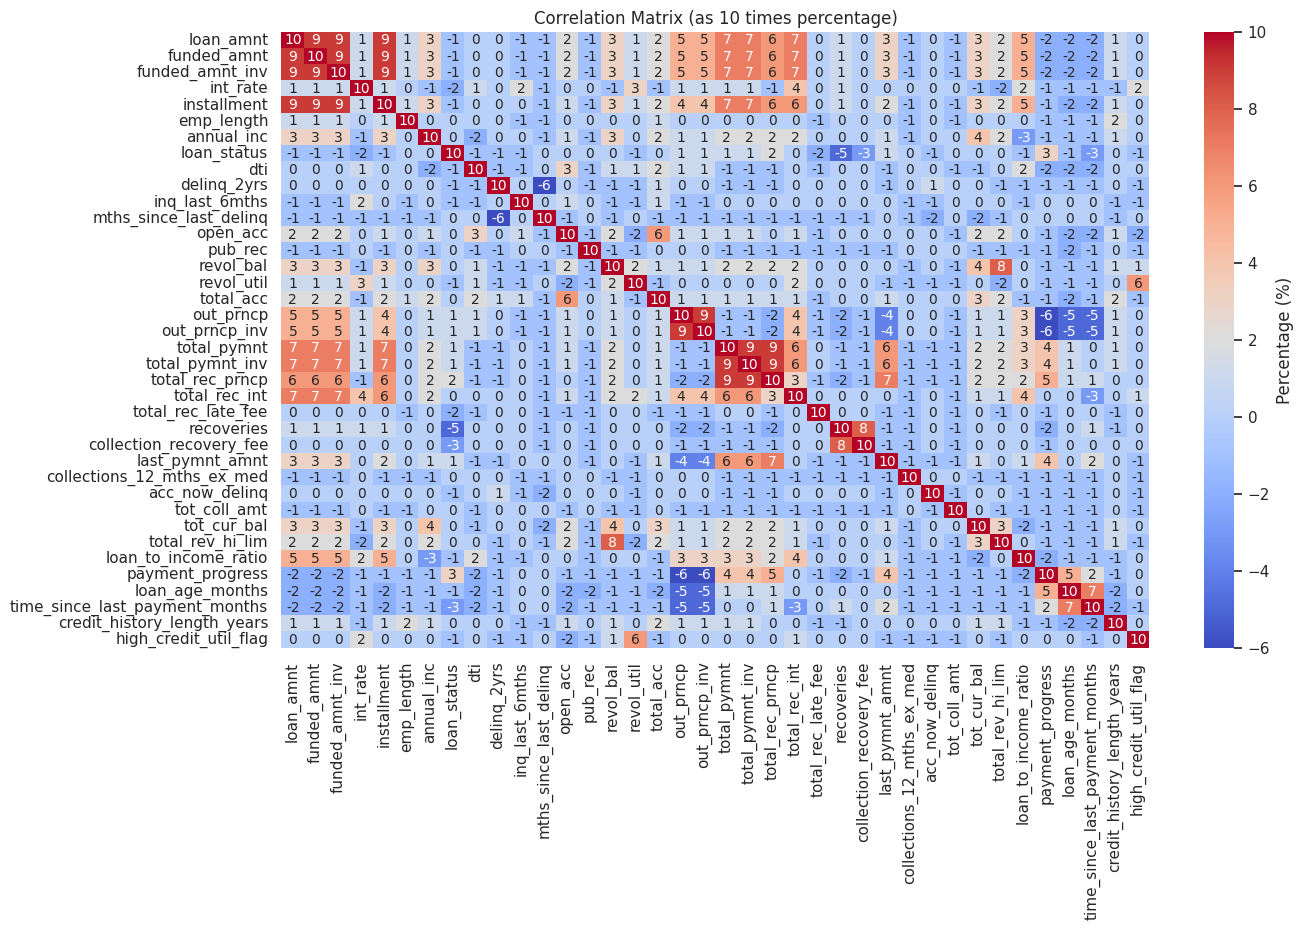

In [ ]:
df['loan_status'] = df['loan_status'].astype(int)

# Select numeric columns
num_cols = df.select_dtypes(include=['float64', 'int64'])

# Calculate correlation and multiply by 100 to get percentages
correlation_matrix = num_cols.corr() * 100 // 10

# Create the heatmap with single digit percentage
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.0f', cmap='coolwarm', cbar_kws={'label': 'Percentage (%)'}, annot_kws={"size": 10})

# Title
plt.title('Correlation Matrix (as 10 times percentage)')

# Show the plot
plt.show()

In [ ]:
df_ = df.drop(columns=['funded_amnt', 'funded_amnt_inv', 'out_prncp_inv', 'total_pymnt_inv', 'total_pymnt_inv', 'total_rec_int', 'total_rec_prncp','installment', 'collection_recovery_fee', 'total_rev_hi_lim', 'total_pymnt', 'time_since_last_payment_months'], axis=1)

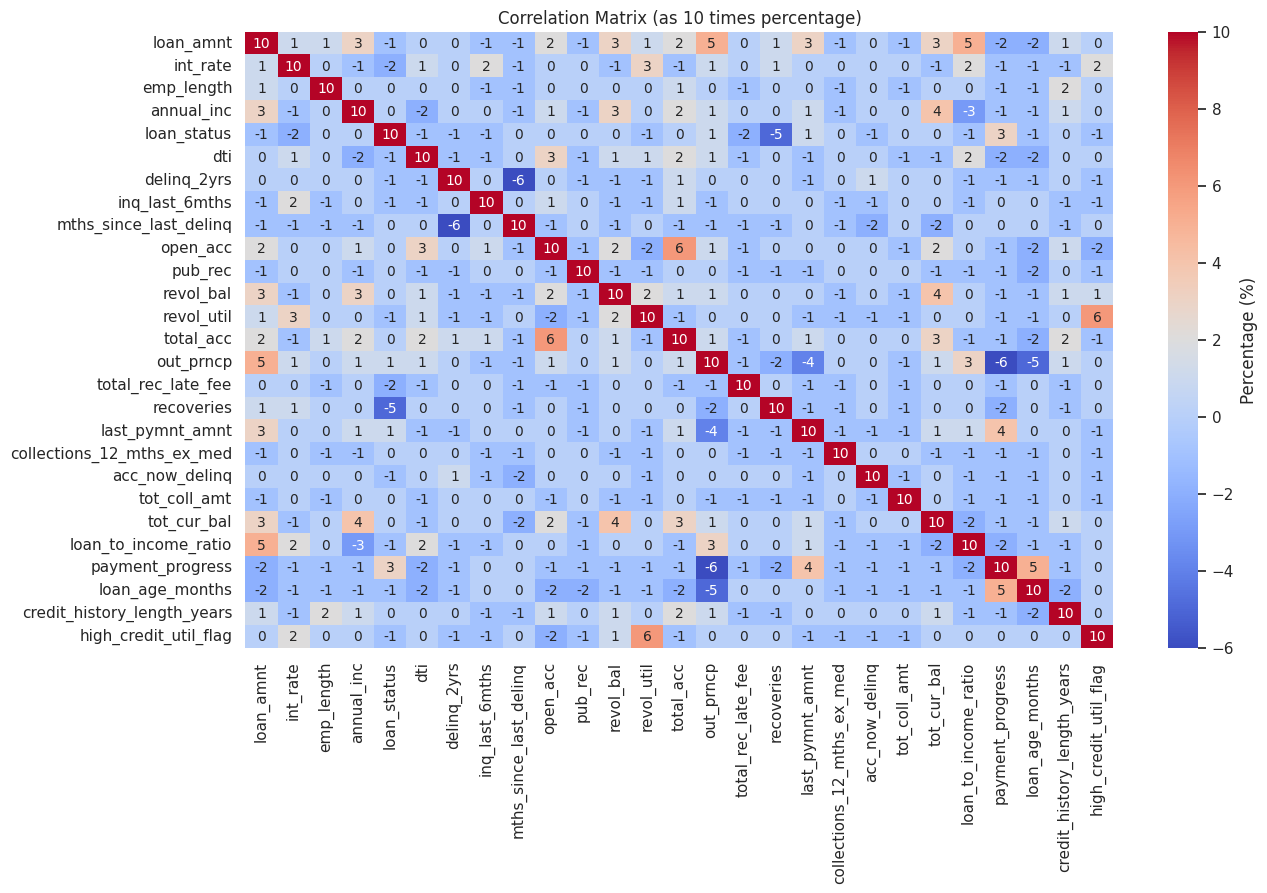

In [ ]:
df['loan_status'] = df['loan_status'].astype(int)

# Select numeric columns
num_cols = df_.select_dtypes(include=['float64', 'int64'])

# Calculate correlation and multiply by 100 to get percentages
correlation_matrix = num_cols.corr() * 100 // 10

# Create the heatmap with single digit percentage
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.0f', cmap='coolwarm', cbar_kws={'label': 'Percentage (%)'}, annot_kws={"size": 10})

# Title
plt.title('Correlation Matrix (as 10 times percentage)')

# Show the plot
plt.show()

In [ ]:
df = df_

In [ ]:
# List of columns to test
columns_to_test = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
columns_to_test = [col for col in columns_to_test if col != 'loan_status']  # Exclude 'loan_status' column

# List to store results
results = []

# Perform t-tests and store results
alpha = 0.05

for column in columns_to_test:
    group1 = df[df['loan_status'] == 1][column].dropna()
    group2 = df[df['loan_status'] == 0][column].dropna()

    t_statistic, p_value = ttest_ind(group1, group2)

    # Store results in the list
    results.append({'Column': column, 'P-Value': p_value})

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
results_df

Column        P-Value
0                     loan_amnt   2.060427e-27
1                      int_rate   0.000000e+00
2                    emp_length   1.021610e-24
3                    annual_inc  2.793986e-248
4                           dti  3.333841e-267
5                   delinq_2yrs   3.325802e-02
6                inq_last_6mths   0.000000e+00
7        mths_since_last_delinq   2.009235e-01
8                      open_acc   1.439080e-02
9                       pub_rec   2.659792e-08
10                    revol_bal   2.483076e-43
11                   revol_util  1.572457e-275
12                    total_acc   4.603951e-46
13                    out_prncp   0.000000e+00
14           total_rec_late_fee   0.000000e+00
15                   recoveries   0.000000e+00
16              last_pymnt_amnt   0.000000e+00
17   collections_12_mths_ex_med   6.586266e-03
18               acc_now_delinq   8.907102e-01
19                 tot_coll_amt   4.484476e-01
20                  tot_cur_bal  1.032724e-221
21         loan_to_income_ratio   0.000000e+00
22             payment_progress   0.000000e+00
23              loan_age_months   0.000000e+00
24  credit_history_length_years  5.195013e-200
25        high_credit_util_flag  7.102533e-129

In [ ]:
insignificant_results_df = results_df[results_df['P-Value'] > alpha]
print("\nInsignificant Results:")
print(insignificant_results_df)


Insignificant Results:
                    Column   P-Value
7   mths_since_last_delinq  0.200923
18          acc_now_delinq  0.890710
19            tot_coll_amt  0.448448


In [ ]:
# Convert 'loan_status' to string if needed
df['loan_status'] = df['loan_status'].astype(str)

# Select categorical columns
cats = df.select_dtypes(include=['object']).columns.to_list()

# Initialize DataFrames to store chi-square test results
chi2_results = pd.DataFrame(index=cats, columns=cats)  # For Chi-square statistics
p_values = pd.DataFrame(index=cats, columns=cats)      # For p-values

# Handle missing values: Drop rows with NaN in categorical columns
df_clean = df[cats].dropna()

# Perform chi-square test for each pair of categorical variables
for feature1 in cats:
    for feature2 in cats:
        # Create a contingency table
        contingency_table = pd.crosstab(df_clean[feature1], df_clean[feature2])

        # Perform chi-square test
        chi2, p, _, _ = chi2_contingency(contingency_table)

        # Store the results in the DataFrames
        chi2_results.at[feature1, feature2] = chi2
        p_values.at[feature1, feature2] = p

# Convert p-values to numeric type for visualization
p_values = p_values.astype(float)

# Display the chi-square test results
print("Chi-Square Test Results (Chi-Square Statistics):")
print(chi2_results)

# Display the p-values
print("\nP-Values:")
print(p_values)


Chi-Square Test Results (Chi-Square Statistics):
                              term         grade      sub_grade home_ownership verification_status    loan_status       purpose    addr_state initial_list_status
term                 462757.998501  98683.391674  104788.423575    6797.160007        39094.476476    2037.257911   3725.270243   1765.560928         4623.058448
grade                 98683.391674     2776578.0      2313815.0    2581.369765        23141.560781   12661.047599   22765.86191    998.940165          810.815889
sub_grade            104788.423575     2313815.0     11569075.0     3346.86082        25469.882578   13236.815164  24711.237334   1713.885473         1137.511078
home_ownership         6797.160007   2581.369765     3346.86082      1388289.0         3766.492756      926.84479   15112.97049  30604.949726          458.371548
verification_status   39094.476476  23141.560781   25469.882578    3766.492756            925526.0    1091.938341   3916.601738    462.476986

In [ ]:
results_df_cat = np.where(p_values > alpha, 'Insignificant', 'Significant')
results_df_cat = pd.DataFrame(results_df_cat, index=cats, columns=cats)
results_df_cat

term        grade    sub_grade home_ownership verification_status  loan_status      purpose   addr_state initial_list_status
term                 Significant  Significant  Significant    Significant         Significant  Significant  Significant  Significant         Significant
grade                Significant  Significant  Significant    Significant         Significant  Significant  Significant  Significant         Significant
sub_grade            Significant  Significant  Significant    Significant         Significant  Significant  Significant  Significant         Significant
home_ownership       Significant  Significant  Significant    Significant         Significant  Significant  Significant  Significant         Significant
verification_status  Significant  Significant  Significant    Significant         Significant  Significant  Significant  Significant         Significant
loan_status          Significant  Significant  Significant    Significant         Significant  Significant  Significant  Significant         Significant
purpose              Significant  Significant  Significant    Significant         Significant  Significant  Significant  Significant         Significant
addr_state           Significant  Significant  Significant    Significant         Significant  Significant  Significant  Significant         Significant
initial_list_status  Significant  Significant  Significant    Significant         Significant  Significant  Significant  Significant         Significant

Kesimpulan

# Modelling

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 462763 entries, 0 to 466284
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   loan_amnt                    462763 non-null  int64         
 1   term                         462763 non-null  object        
 2   int_rate                     462763 non-null  float64       
 3   grade                        462763 non-null  object        
 4   sub_grade                    462763 non-null  object        
 5   emp_length                   441828 non-null  float64       
 6   home_ownership               462763 non-null  object        
 7   annual_inc                   462763 non-null  float64       
 8   verification_status          462763 non-null  object        
 9   issue_d                      462763 non-null  datetime64[ns]
 10  loan_status                  462763 non-null  object        
 11  purpose                      46

In [ ]:
unrelated_cols = ['loan_amnt', 'initial_list_status', 'out_prncp', 'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'issue_yr', 'issue_mon', 'last_pymnt_yr', 'last_pymnt_mon', 'loan_to_income_ratio', 'payment_progress', 'loan_age_months', 'credit_history_length_years', 'high_credit_util_flag']

df = df.drop(columns=unrelated_cols, axis=1)

In [ ]:
dtime_cols = ['issue_d', 'last_pymnt_d', 'earliest_cr_line']

df = df.drop(columns=dtime_cols, axis=1)

In [ ]:
df['loan_status'] = df['loan_status'].astype(int)

In [ ]:
df['loan_status'].value_counts()

loan_status
1    411763
0     51000
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 462763 entries, 0 to 466284
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   term                    462763 non-null  object 
 1   int_rate                462763 non-null  float64
 2   grade                   462763 non-null  object 
 3   sub_grade               462763 non-null  object 
 4   emp_length              441828 non-null  float64
 5   home_ownership          462763 non-null  object 
 6   annual_inc              462763 non-null  float64
 7   verification_status     462763 non-null  object 
 8   loan_status             462763 non-null  int64  
 9   purpose                 462763 non-null  object 
 10  addr_state              462763 non-null  object 
 11  dti                     462763 non-null  float64
 12  delinq_2yrs             462763 non-null  float64
 13  inq_last_6mths          462763 non-null  float64
 14  mths_since_last_delinq  2

In [ ]:
X, y = df.drop('loan_status', axis=1), df['loan_status']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
categorical_features = X_train.select_dtypes(include=['object']).columns.to_list()
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()

# Define the numerical transformer
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Handle missing values
    ("scaler", RobustScaler()) # Standardize numerical features
])

# Define the categorical transformer
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Handle missing values in categorical columns
    ("onehot", OneHotEncoder(handle_unknown="ignore"))  # One-hot encode categorical features
])

# Define the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Define the model pipeline with increased iterations and scaling
def create_pipeline(model):
    return ImbPipeline([
        ("preprocessor", preprocessor),  # Apply preprocessing steps
        ("smote", SMOTE(random_state=42)),  # Apply SMOTE for balancing
        ("model", model)  # Specify the ML model
    ])


In [ ]:
# Evaluate each model using multiple metrics
metrics = {
    'Recall': make_scorer(recall_score),
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'ROC AUC': make_scorer(roc_auc_score, needs_proba=True),
    'F1 Score': make_scorer(f1_score)
}

# Perform Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(solver='saga', max_iter=100, random_state=42)
    #,"Decision Tree": DecisionTreeClassifier(),
    #"Random Forest": RandomForestClassifier(),
    #"XGBoost": XGBClassifier(eval_metric="logloss"),
    #"LightGBM": LGBMClassifier(),
    #"CatBoost": CatBoostClassifier(verbose=0),
    #"SVM": SVC(probability=True),
    #"KNN": KNeighborsClassifier(),
    #"Neural Network": MLPClassifier(max_iter=1000)
}

# Perform Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
results = {}

for name, model in models.items():
    pipeline = create_pipeline(model)

    # Perform cross-validation with multiple scoring metrics
    scores = cross_validate(pipeline, X_train, y_train, scoring=metrics, cv=cv, return_train_score=False)

    # Store results for each metric
    results[name] = {
        metric_name: {
            "Mean": np.mean(scores[f"test_{metric_name}"]),
            "Std Dev": np.std(scores[f"test_{metric_name}"])
        }
        for metric_name in metrics.keys()
    }

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame({
    model_name: {
        metric_name: f"Mean = {metric_scores['Mean']:.4f}, Std Dev = {metric_scores['Std Dev']:.4f}"
        for metric_name, metric_scores in metrics_scores.items()
    }
    for model_name, metrics_scores in results.items()
})

print("\nModel Performance (Mean and Std Dev for Each Metric):")
print(results_df)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Model Performance (Mean and Std Dev for Each Metric):
                       Logistic Regression
Recall     Mean = 0.6149, Std Dev = 0.0033
Accuracy   Mean = 0.6173, Std Dev = 0.0031
Precision  Mean = 0.9315, Std Dev = 0.0009
ROC AUC    Mean = 0.6718, Std Dev = 0.0030
F1 Score   Mean = 0.7408, Std Dev = 0.0026


In [ ]:
results_df

Logistic Regression
Recall     Mean = 0.6149, Std Dev = 0.0033
Accuracy   Mean = 0.6173, Std Dev = 0.0031
Precision  Mean = 0.9315, Std Dev = 0.0009
ROC AUC    Mean = 0.6718, Std Dev = 0.0030
F1 Score   Mean = 0.7408, Std Dev = 0.0026

In [ ]:
# Evaluate the trained model on the test set
test_results = {}

for name, model in models.items():
    # Create and train the pipeline
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None

    # Calculate metrics
    test_results[name] = {
        "Recall": recall_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A",
    }

# Convert results to a DataFrame for better visualization
test_results_df = pd.DataFrame(test_results).T

print("\nTest Set Performance:")
print(test_results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Test Set Performance:
                      Recall  Accuracy  Precision  F1 Score   ROC AUC
Logistic Regression  0.61581  0.616965   0.930737  0.741209  0.667842


In [ ]:
model_dt = {
    #"Logistic Regression": LogisticRegression(max_iter=5000, solver='lbfgs')
    "Decision Tree": DecisionTreeClassifier()
    #"Random Forest": RandomForestClassifier(),
    #"XGBoost": XGBClassifier(eval_metric="logloss"),
    #"LightGBM": LGBMClassifier(),
    #"CatBoost": CatBoostClassifier(verbose=0),
    #"SVM": SVC(probability=True),
    #"KNN": KNeighborsClassifier(),
    #"Neural Network": MLPClassifier(max_iter=1000)
}

In [ ]:
results = {}

for name, model in model_dt.items():
    pipeline = create_pipeline(model)

    # Perform cross-validation with multiple scoring metrics
    scores = cross_validate(pipeline, X_train, y_train, scoring=metrics, cv=cv, return_train_score=False)

    # Store results for each metric
    results[name] = {
        metric_name: {
            "Mean": np.mean(scores[f"test_{metric_name}"]),
            "Std Dev": np.std(scores[f"test_{metric_name}"])
        }
        for metric_name in metrics.keys()
    }

# Convert results to a DataFrame for better visualization
result_dt_df = pd.DataFrame({
    model_name: {
        metric_name: f"Mean = {metric_scores['Mean']:.4f}, Std Dev = {metric_scores['Std Dev']:.4f}"
        for metric_name, metric_scores in metrics_scores.items()
    }
    for model_name, metrics_scores in results.items()
})

In [ ]:
result_dt_df

Decision Tree
Recall     Mean = 0.8711, Std Dev = 0.0011
Accuracy   Mean = 0.7938, Std Dev = 0.0012
Precision  Mean = 0.8944, Std Dev = 0.0005
ROC AUC    Mean = 0.5212, Std Dev = 0.0022
F1 Score   Mean = 0.8826, Std Dev = 0.0007

In [ ]:
# Evaluate the trained model on the test set
test_results = {}

for name, model in model_dt.items():
    # Create and train the pipeline
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None

    # Calculate metrics
    test_results[name] = {
        "Recall": recall_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A",
    }

# Convert results to a DataFrame for better visualization
test_result_dt_df = pd.DataFrame(test_results).T

print("\nTest Set Performance:")
print(test_result_dt_df)


Test Set Performance:
                Recall  Accuracy  Precision  F1 Score   ROC AUC
Decision Tree  0.87169  0.795447   0.895857  0.883609  0.522771


In [ ]:
model_xgb = {
    #"Logistic Regression": LogisticRegression(max_iter=5000, solver='lbfgs')
    #"Decision Tree": DecisionTreeClassifier()
    #"Random Forest": RandomForestClassifier()
    "XGBoost": XGBClassifier(eval_metric="logloss")
    #"LightGBM": LGBMClassifier(),
    #"CatBoost": CatBoostClassifier(verbose=0),
    #"SVM": SVC(probability=True),
    #"KNN": KNeighborsClassifier(),
    #"Neural Network": MLPClassifier(max_iter=1000)
}

In [ ]:
results = {}

for name, model in model_xgb.items():
    pipeline = create_pipeline(model)

    # Perform cross-validation with multiple scoring metrics
    scores = cross_validate(pipeline, X_train, y_train, scoring=metrics, cv=cv, return_train_score=False)

    # Store results for each metric
    results[name] = {
        metric_name: {
            "Mean": np.mean(scores[f"test_{metric_name}"]),
            "Std Dev": np.std(scores[f"test_{metric_name}"])
        }
        for metric_name in metrics.keys()
    }

# Convert results to a DataFrame for better visualization
result_xgb_df = pd.DataFrame({
    model_name: {
        metric_name: f"Mean = {metric_scores['Mean']:.4f}, Std Dev = {metric_scores['Std Dev']:.4f}"
        for metric_name, metric_scores in metrics_scores.items()
    }
    for model_name, metrics_scores in results.items()
})

In [ ]:
result_xgb_df

XGBoost
Recall     Mean = 0.9999, Std Dev = 0.0000
Accuracy   Mean = 0.8895, Std Dev = 0.0000
Precision  Mean = 0.8896, Std Dev = 0.0000
ROC AUC    Mean = 0.6762, Std Dev = 0.0031
F1 Score   Mean = 0.9415, Std Dev = 0.0000

In [ ]:
# Evaluate the trained model on the test set
test_results = {}

for name, model in model_xgb.items():
    # Create and train the pipeline
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None

    # Calculate metrics
    test_results[name] = {
        "Recall": recall_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A",
    }

# Convert results to a DataFrame for better visualization
test_result_xgb_df = pd.DataFrame(test_results).T

print("\nTest Set Performance:")
print(test_result_xgb_df)


Test Set Performance:
           Recall  Accuracy  Precision  F1 Score  ROC AUC
XGBoost  0.999951  0.890765   0.890797  0.942223  0.67306


In [ ]:
# Define a streamlined hyperparameter grid
xgb_param_grid = {
    'model__n_estimators': [50, 100],  # Focus on smaller ranges
    'model__learning_rate': [0.05, 0.1],  # Conservative step sizes
    'model__max_depth': [3, 5],  # Fewer options for tree depth
    'model__subsample': [0.8, 1.0],  # Slight variation in subsample ratio
    'model__colsample_bytree': [0.8, 1.0],  # Column sampling ratios
    'model__gamma': [0, 1],  # Simpler gamma range
}

# Set up RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=xgb_param_grid,
    n_iter=8,  # Fewer combinations for faster execution
    scoring='roc_auc',  # Optimize for ROC AUC
    cv=cv,  # Stratified K-Fold Cross-Validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Fit the RandomizedSearchCV to the training data
random_search_xgb.fit(X_train, y_train)

# Print results
print("Best Parameters for XGBoost:", random_search_xgb.best_params_)
print("Best ROC AUC Score (Train):", random_search_xgb.best_score_)

# Evaluate on the test set
best_xgb_pipeline = random_search_xgb.best_estimator_
y_test_pred_proba = best_xgb_pipeline.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)
print("Test ROC AUC Score:", roc_auc_test)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for XGBoost: {'model__subsample': 0.8, 'model__n_estimators': 50, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 0.8}
Best ROC AUC Score (Train): 0.6463441825360319
Test ROC AUC Score: 0.6443112122695265


In [ ]:
# Evaluate on the test set
best_xgb_pipeline = random_search_xgb.best_estimator_
y_test_pred_proba = best_xgb_pipeline.predict_proba(X_test)[:, 1]
y_test_pred = best_xgb_pipeline.predict(X_test)
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)
print("Test ROC AUC Score:", roc_auc_test)

# Calculate metrics for the test set
test_metrics = {
    "Recall": recall_score(y_test, y_test_pred),
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred),
    "F1 Score": f1_score(y_test, y_test_pred),
    "ROC AUC": roc_auc_score(y_test, y_test_pred_proba),
}

# Display the test set metrics
print("\nTest Set Performance with Tuned Model:")
print(pd.DataFrame(test_metrics, index=["Score"]).T)

Test ROC AUC Score: 0.6443112122695265

Test Set Performance with Tuned Model:
              Score
Recall     1.000000
Accuracy   0.890744
Precision  0.890744
F1 Score   0.942215
ROC AUC    0.644311


In [ ]:
# Evaluate on the test set
best_xgb_pipeline = random_search_xgb.best_estimator_
y_train_pred_proba = best_xgb_pipeline.predict_proba(X_train)[:, 1]
y_train_pred = best_xgb_pipeline.predict(X_train)
roc_auc_test = roc_auc_score(y_train, y_train_pred_proba)
print("Test ROC AUC Score:", roc_auc_test)

# Calculate metrics for the test set
test_metrics = {
    "Recall": recall_score(y_train, y_train_pred),
    "Accuracy": accuracy_score(y_train, y_train_pred),
    "Precision": precision_score(y_train, y_train_pred),
    "F1 Score": f1_score(y_train, y_train_pred),
    "ROC AUC": roc_auc_score(y_train, y_train_pred_proba),
}

# Display the test set metrics
print("\nTrain Set Performance with Tuned Model:")
print(pd.DataFrame(test_metrics, index=["Score"]).T)

Test ROC AUC Score: 0.6454887532779604

Train Set Performance with Tuned Model:
              Score
Recall     1.000000
Accuracy   0.889555
Precision  0.889555
F1 Score   0.941549
ROC AUC    0.645489


In [ ]:
# Evaluate the tuned model on the training set
y_train_pred = best_xgb_pipeline.predict(X_train)  # Predict the class labels for training set
y_train_pred_proba = best_xgb_pipeline.predict_proba(X_train)[:, 1]  # Predict probabilities for training set

# Calculate training metrics
train_recall = recall_score(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)

# Evaluate the tuned model on the test set
y_test_pred = best_xgb_pipeline.predict(X_test)  # Predict the class labels for test set
y_test_pred_proba = best_xgb_pipeline.predict_proba(X_test)[:, 1]  # Predict probabilities for test set

# Calculate test metrics
test_recall = recall_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)

# Print the results
print("\nTraining Set Metrics for Tuned XGBoost:")
print(f"Recall: {train_recall:.4f}")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print(f"ROC AUC: {roc_auc_train:.4f}")

print("\nTest Set Metrics for Tuned XGBoost:")
print(f"Recall: {test_recall:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"ROC AUC: {roc_auc_test:.4f}")

# Optionally, display classification reports for further insights
print("\nClassification Report for Training Set:")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_pred))


Training Set Metrics for Tuned XGBoost:
Recall: 1.0000
Accuracy: 0.8896
Precision: 0.8896
F1 Score: 0.9415
ROC AUC: 0.6455

Test Set Metrics for Tuned XGBoost:
Recall: 1.0000
Accuracy: 0.8907
Precision: 0.8907
F1 Score: 0.9422
ROC AUC: 0.6443

Classification Report for Training Set:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     40888
           1       0.89      1.00      0.94    329322

    accuracy                           0.89    370210
   macro avg       0.44      0.50      0.47    370210
weighted avg       0.79      0.89      0.84    370210


Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10112
           1       0.89      1.00      0.94     82441

    accuracy                           0.89     92553
   macro avg       0.45      0.50      0.47     92553
weighted avg       0.79      0.89      0.84     92553



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


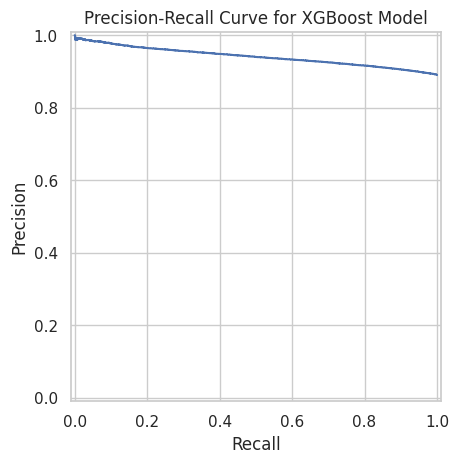

In [ ]:
# Generate predicted probabilities for the positive class (1)
y_pred_curve = pipeline.predict_proba(X_test)[:, 1]  # Use the best pipeline from tuning

# Compute precision, recall, and thresholds
precision, recall, threshold = precision_recall_curve(y_test, y_pred_curve)

# Plot the Precision-Recall curve
prd = PrecisionRecallDisplay(precision, recall)
prd.plot()
plt.title("Precision-Recall Curve for XGBoost Model")
plt.show()

In [ ]:
# Generate predicted probabilities for the positive class (1)
y_pred_curve = pipeline.predict_proba(X_test)[:, 1]  # Use the best pipeline from tuning

# Compute precision, recall, and thresholds
precision, recall, threshold = precision_recall_curve(y_test, y_pred_curve)

pr_table = pd.DataFrame({
    "Threshold": threshold,
    "Precision": precision[:-1],  # Last value of precision is omitted
    "Recall": recall[:-1],        # Last value of recall is omitted
})

# Find the threshold where precision is close to recall
pr_table["Difference"] = abs(pr_table["Precision"] - pr_table["Recall"])
optimal_threshold = pr_table.loc[pr_table["Difference"].idxmin(), "Threshold"]
print("Optimal Threshold:", optimal_threshold)
print("Optimal Recall:", pr_table.loc[pr_table["Difference"].idxmin(), ["Recall"]])
print("Optimal Precision:", pr_table.loc[pr_table["Difference"].idxmin(), ["Precision"]])

plt.figure(figsize=(10, 6))
plt.plot(threshold, precision[:-1], label="Precision", color="blue")
plt.plot(threshold, recall[:-1], label="Recall", color="orange")
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.title("Precision-Recall vs. Threshold", fontsize=16)
plt.legend(loc="lower left", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Optimal Threshold: 0.78539973
Optimal Recall: Recall    0.905108
Name: 10065, dtype: float64
Optimal Precision: Precision    0.905108
Name: 10065, dtype: float64


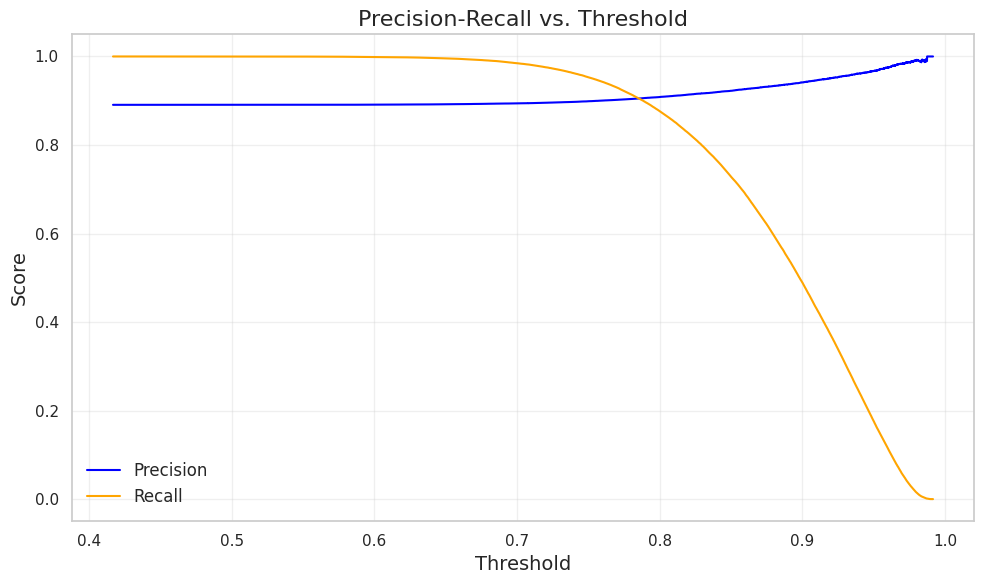

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(threshold, precision[:-1], label="Precision", color="blue")
plt.plot(threshold, recall[:-1], label="Recall", color="orange")
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.title("Precision-Recall vs. Threshold", fontsize=16)
plt.legend(loc="lower left", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1000x2000 with 0 Axes>

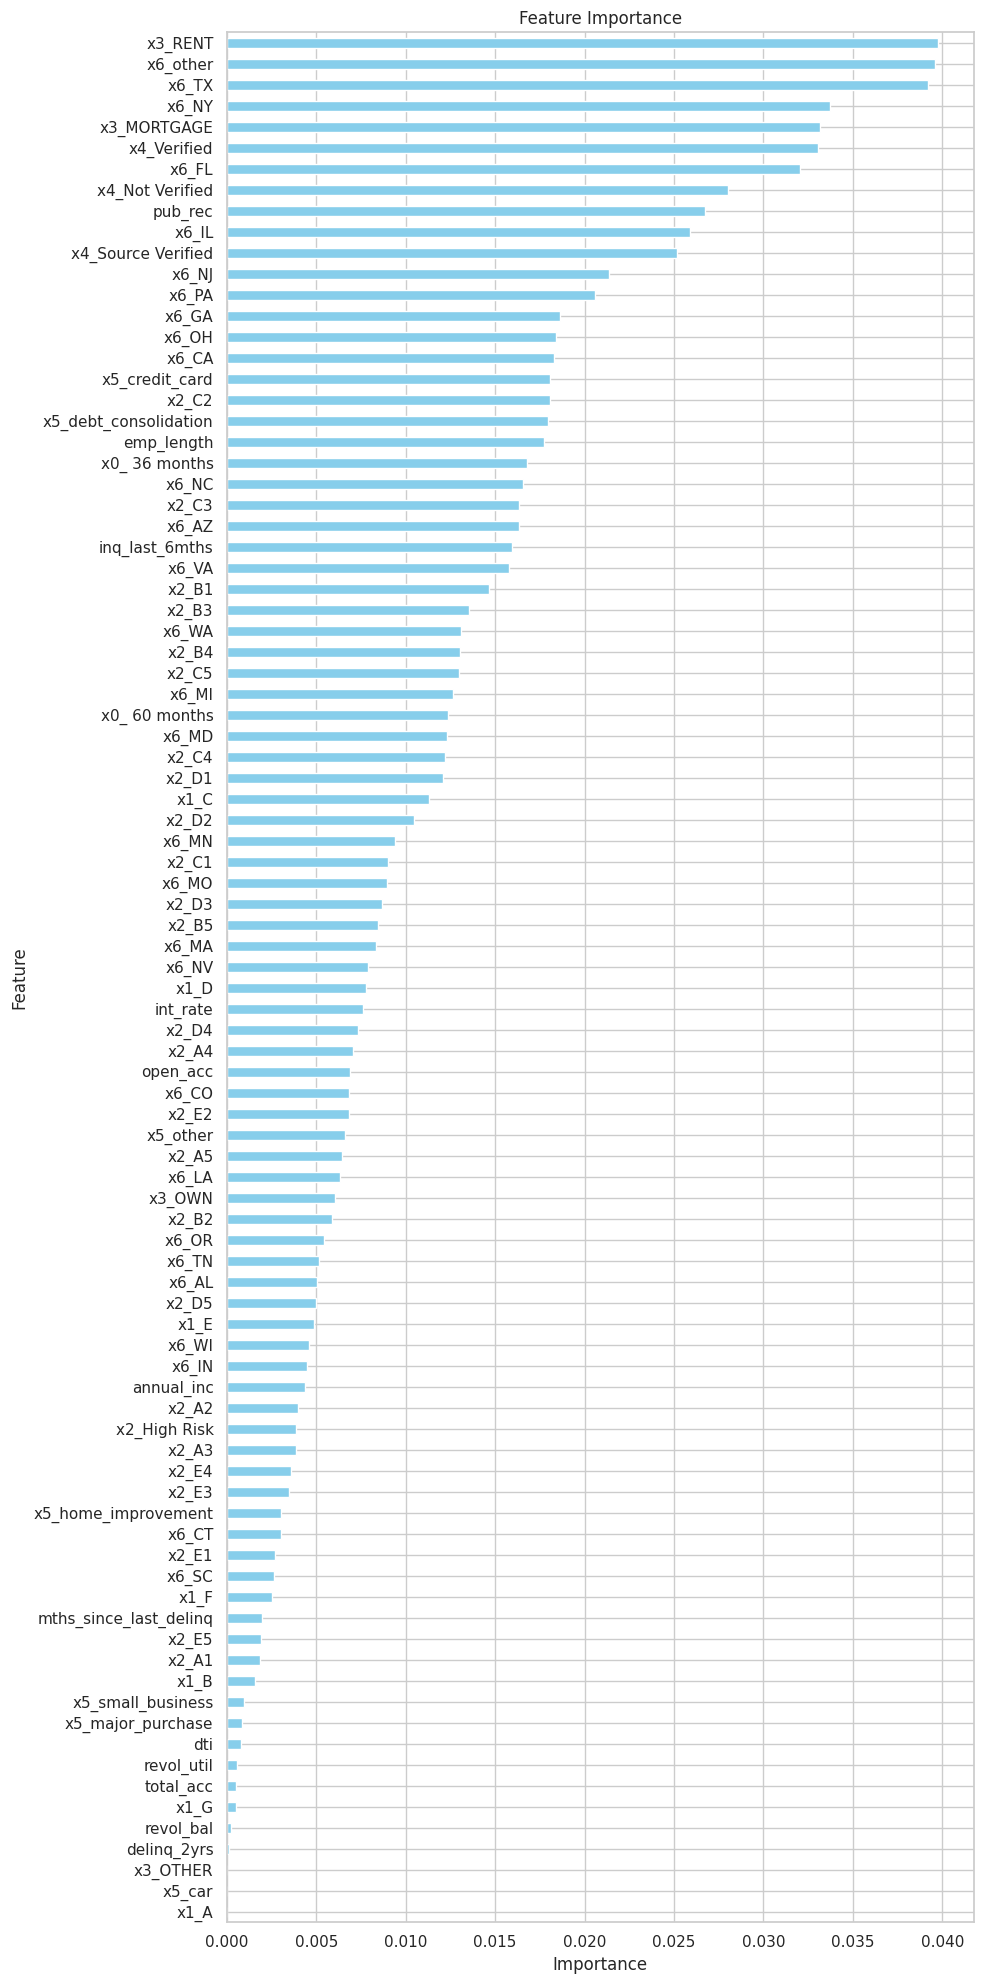

In [ ]:
# Train the pipeline if not already fitted
pipeline.fit(X_train, y_train)

# Extract the trained model from the pipeline
model = pipeline.named_steps['model']

# Ensure the model provides feature importances (tree-based models like LightGBM)
if hasattr(model, 'feature_importances_'):
    # Extract feature importances
    feature_importances = model.feature_importances_

    # Get the numerical feature names
    numerical_features = preprocessor.transformers_[0][2]

    # Get the categorical feature names from the one-hot encoder
    categorical_features = pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out()

    # Combine numerical and categorical feature names
    all_features = list(numerical_features) + list(categorical_features)

    # Ensure the lengths match between feature names and importances
    if len(feature_importances) != len(all_features):
        print("Length mismatch between feature importances and feature names.")
    else:
        # Create a DataFrame for feature importance
        feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': feature_importances})

        # Sort by importance for better visualization
        feature_importance_df = feature_importance_df.sort_values('Importance', ascending=True)

        # Plot feature importance
        plt.figure(figsize=(10, 20))
        feature_importance_df.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 20), legend=False, color='skyblue')
        plt.title('Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

else:
    print("The selected model does not provide feature importances.")


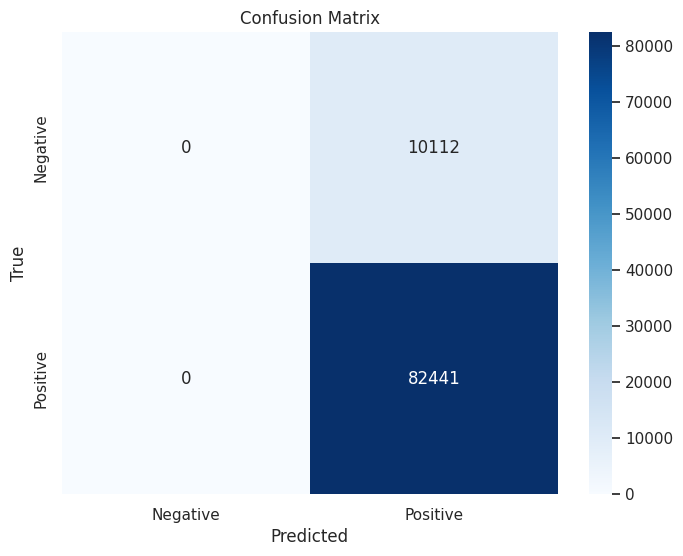

In [ ]:
# Assuming the pipeline has been fitted on the training data
y_pred = pipeline.predict(X_test)  # Predict on the test set

# Generate confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
TP = cm_xgb[1][1]
FN = cm_xgb[1][0]
FP = cm_xgb[0][1]
TN = cm_xgb[0][0]

In [ ]:
persentase_kesalahan_model = (FP / (TP+FP+TN+FN)) * 100

print(f'Persentase kesalahan prediksi resiko pinjaman yang menimbulkan kerugian: {persentase_kesalahan_model:.2f}%')

persentase_kesalahan_model = (FN / (TP+FP+TN+FN)) * 100

print(f'Persentase kesalahan prediksi resiko pinjaman yang menimbulkan profit tidak maksimal: {persentase_kesalahan_model:.2f}%')

Persentase kesalahan prediksi resiko pinjaman yang menimbulkan kerugian: 10.92%
Persentase kesalahan prediksi resiko pinjaman yang menimbulkan profit tidak maksimal: 0.00%


In [ ]:
model_lgbm = {
    #"Logistic Regression": LogisticRegression(max_iter=5000, solver='lbfgs')
    #"Decision Tree": DecisionTreeClassifier()
    #"Random Forest": RandomForestClassifier()
    #"XGBoost": XGBClassifier(eval_metric="logloss")
    "LightGBM": LGBMClassifier()
    #"CatBoost": CatBoostClassifier(verbose=0),
    #"SVM": SVC(probability=True)
    #"KNN": KNeighborsClassifier()
    #"Neural Network": MLPClassifier(max_iter=1000)
}

In [ ]:
results = {}

for name, model in model_lgbm.items():
    pipeline = create_pipeline(model)

    # Perform cross-validation with multiple scoring metrics
    scores = cross_validate(pipeline, X_train, y_train, scoring=metrics, cv=cv, return_train_score=False)

    # Store results for each metric
    results[name] = {
        metric_name: {
            "Mean": np.mean(scores[f"test_{metric_name}"]),
            "Std Dev": np.std(scores[f"test_{metric_name}"])
        }
        for metric_name in metrics.keys()
    }

# Convert results to a DataFrame for better visualization
result_lgbm_df = pd.DataFrame({
    model_name: {
        metric_name: f"Mean = {metric_scores['Mean']:.4f}, Std Dev = {metric_scores['Std Dev']:.4f}"
        for metric_name, metric_scores in metrics_scores.items()
    }
    for model_name, metrics_scores in results.items()
})

[LightGBM] [Info] Number of positive: 263457, number of negative: 263457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.402229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22721
[LightGBM] [Info] Number of data points in the train set: 526914, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 263457, number of negative: 263457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.398003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22716
[LightGBM] [Info] Number of data points in the train set: 526914, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> inits

In [ ]:
result_lgbm_df

LightGBM
Recall     Mean = 1.0000, Std Dev = 0.0000
Accuracy   Mean = 0.8896, Std Dev = 0.0000
Precision  Mean = 0.8896, Std Dev = 0.0000
ROC AUC    Mean = 0.6808, Std Dev = 0.0030
F1 Score   Mean = 0.9415, Std Dev = 0.0000

In [ ]:
# Evaluate the trained model on the test set
test_results = {}

for name, model in model_lgbm.items():
    # Create and train the pipeline
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None

    # Calculate metrics
    test_results[name] = {
        "Recall": recall_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A",
    }

# Convert results to a DataFrame for better visualization
test_result_lgbm_df = pd.DataFrame(test_results).T

print("\nTest Set Performance:")
print(test_result_lgbm_df)

[LightGBM] [Info] Number of positive: 329322, number of negative: 329322
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.714625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22715
[LightGBM] [Info] Number of data points in the train set: 658644, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Test Set Performance:
          Recall  Accuracy  Precision  F1 Score   ROC AUC
LightGBM     1.0  0.890744   0.890744  0.942215  0.677211


In [ ]:
# Define a smaller parameter grid
param_dist = {
    "model__num_leaves": randint(20, 40),  # Narrow range for number of leaves
    "model__learning_rate": uniform(0.03, 0.07),  # Slightly broader focus on learning rates
    "model__n_estimators": randint(50, 150),  # Fewer boosting rounds
    "model__max_depth": randint(3, 7),  # Limit depth for better generalization
    "model__subsample": uniform(0.7, 0.3),  # Subsampling to prevent overfitting
    "model__colsample_bytree": uniform(0.7, 0.3),  # Column sampling
}

# Use fewer iterations and splits
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=15,  # Fewer iterations
    scoring="roc_auc",  # Optimize for ROC AUC
    cv=3,  # Use 3-fold CV for efficiency
    verbose=2,  # Print progress
    random_state=42,  # Ensure reproducibility
    n_jobs=-1  # Use all available processors
)

# Perform hyperparameter tuning
random_search.fit(X_train, y_train)

# Display the best parameters and best ROC AUC score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation ROC AUC Score:", random_search.best_score_)

# Evaluate the tuned model on the test set
best_pipeline = random_search.best_estimator_  # Get the best pipeline
y_test_pred = best_pipeline.predict(X_test)
y_test_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Calculate metrics for the test set
test_metrics = {
    "Recall": recall_score(y_test, y_test_pred),
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred),
    "F1 Score": f1_score(y_test, y_test_pred),
    "ROC AUC": roc_auc_score(y_test, y_test_pred_proba),
}

# Display the test set metrics
print("\nTest Set Performance with Tuned Model:")
print(pd.DataFrame(test_metrics, index=["Score"]).T)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


KeyboardInterrupt: 

In [ ]:
# Evaluate the tuned model on the test set
best_pipeline = random_search.best_estimator_  # Get the best pipeline
y_train_pred = best_pipeline.predict(X_train)
y_train_pred_proba = best_pipeline.predict_proba(X_train)[:, 1]

# Calculate metrics for the test set
test_metrics = {
    "Recall": recall_score(y_train, y_train_pred),
    "Accuracy": accuracy_score(y_train, y_train_pred),
    "Precision": precision_score(y_train, y_train_pred),
    "F1 Score": f1_score(y_train, y_train_pred),
    "ROC AUC": roc_auc_score(y_train, y_train_pred_proba),
}

# Display the test set metrics
print("\nTrain Set Performance with Tuned Model:")
print(pd.DataFrame(test_metrics, index=["Score"]).T)


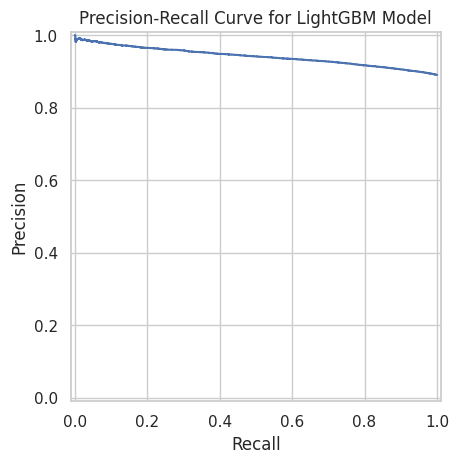

In [ ]:
# Generate predicted probabilities for the positive class (1)
y_pred_curve = pipeline.predict_proba(X_test)[:, 1]  # Use the best pipeline from tuning

# Compute precision, recall, and thresholds
precision, recall, threshold = precision_recall_curve(y_test, y_pred_curve)

# Plot the Precision-Recall curve
prd = PrecisionRecallDisplay(precision, recall)
prd.plot()
plt.title("Precision-Recall Curve for LightGBM Model")
plt.show()


Optimal Threshold: 0.7730141055590107
Optimal Recall: Recall    0.905363
Name: 10111, dtype: float64
Optimal Precision: Precision    0.905363
Name: 10111, dtype: float64


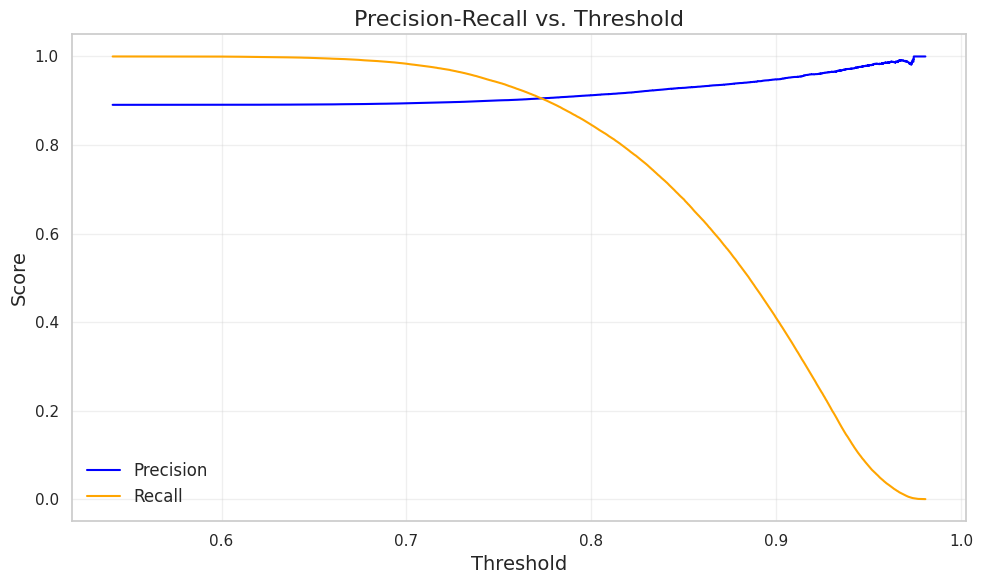

In [ ]:
# Generate predicted probabilities for the positive class (1)
y_pred_curve = pipeline.predict_proba(X_test)[:, 1]  # Use the best pipeline from tuning

# Compute precision, recall, and thresholds
precision, recall, threshold = precision_recall_curve(y_test, y_pred_curve)

pr_table = pd.DataFrame({
    "Threshold": threshold,
    "Precision": precision[:-1],  # Last value of precision is omitted
    "Recall": recall[:-1],        # Last value of recall is omitted
})

# Find the threshold where precision is close to recall
pr_table["Difference"] = abs(pr_table["Precision"] - pr_table["Recall"])
optimal_threshold = pr_table.loc[pr_table["Difference"].idxmin(), "Threshold"]
print("Optimal Threshold:", optimal_threshold)
print("Optimal Recall:", pr_table.loc[pr_table["Difference"].idxmin(), ["Recall"]])
print("Optimal Precision:", pr_table.loc[pr_table["Difference"].idxmin(), ["Precision"]])

plt.figure(figsize=(10, 6))
plt.plot(threshold, precision[:-1], label="Precision", color="blue")
plt.plot(threshold, recall[:-1], label="Recall", color="orange")
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.title("Precision-Recall vs. Threshold", fontsize=16)
plt.legend(loc="lower left", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

[LightGBM] [Info] Number of positive: 329322, number of negative: 329322
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.490046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22715
[LightGBM] [Info] Number of data points in the train set: 658644, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


<Figure size 1000x2000 with 0 Axes>

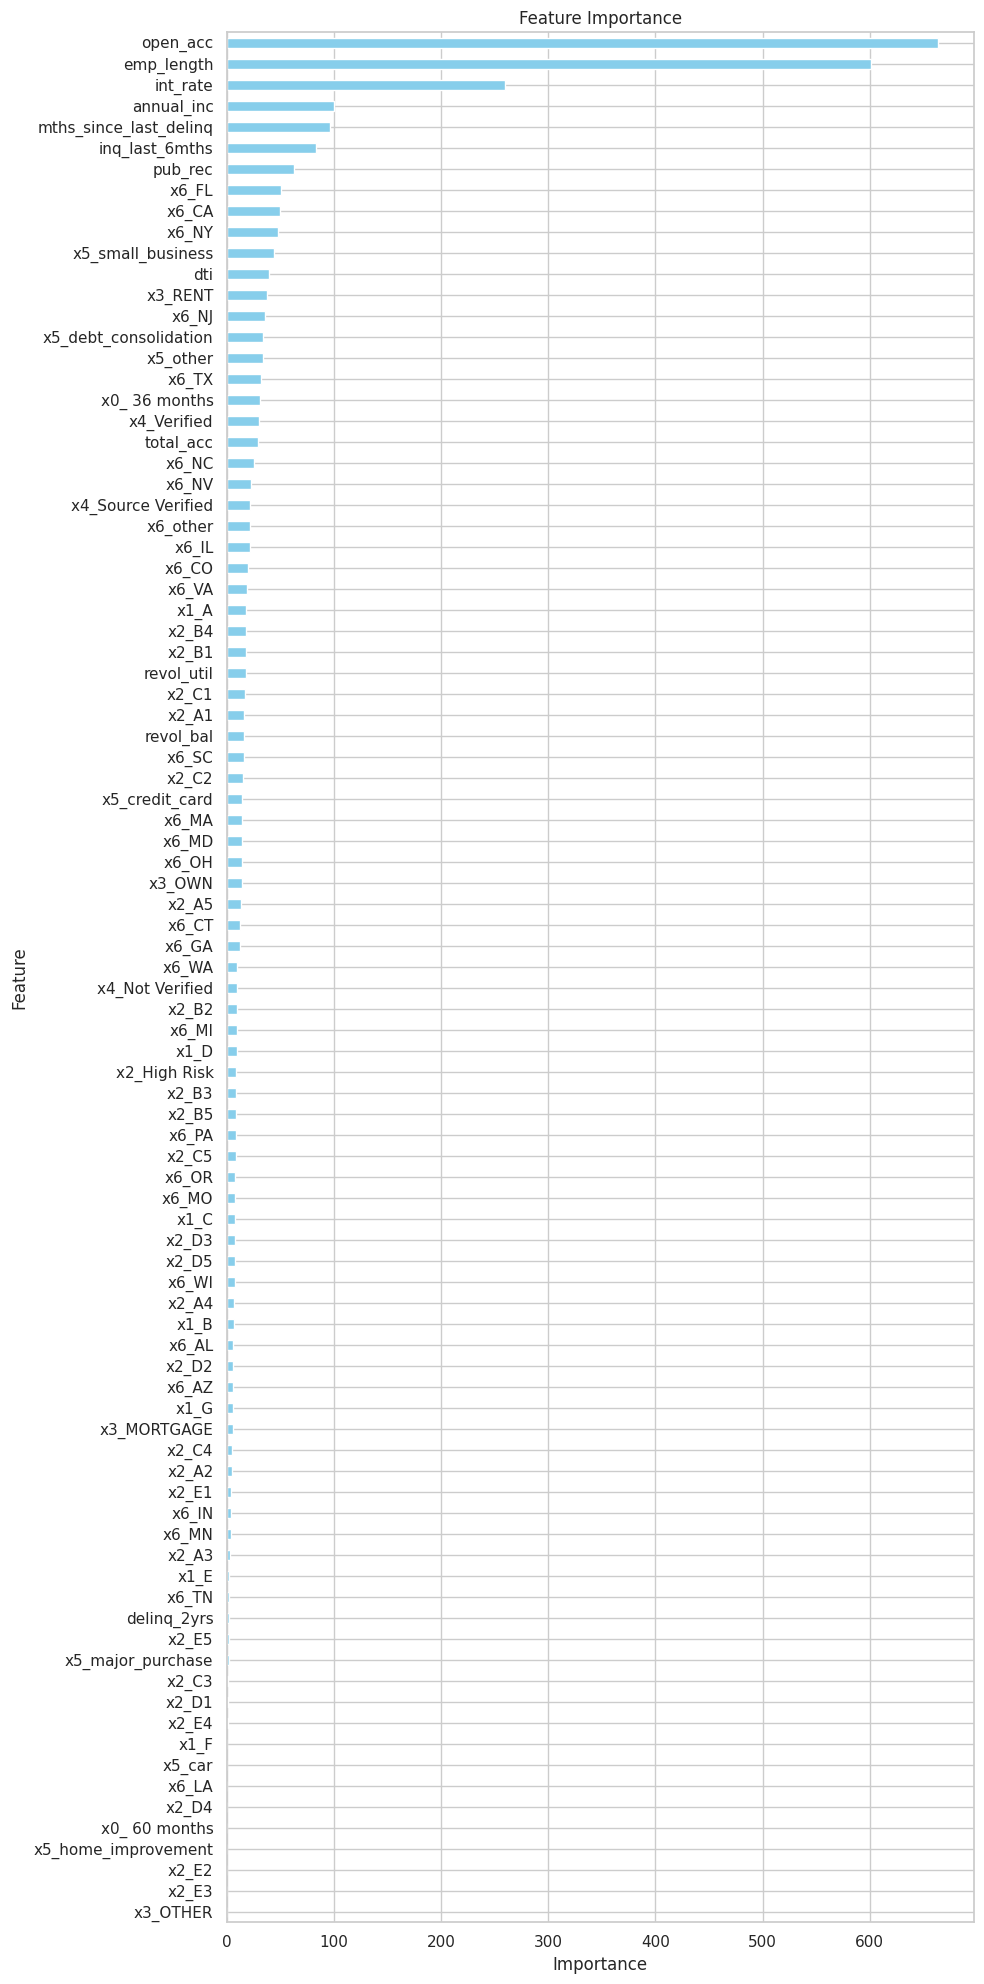

In [ ]:
# Train the pipeline if not already fitted
pipeline.fit(X_train, y_train)

# Extract the trained model from the pipeline
model = pipeline.named_steps['model']

# Ensure the model provides feature importances (tree-based models like LightGBM)
if hasattr(model, 'feature_importances_'):
    # Extract feature importances
    feature_importances = model.feature_importances_

    # Get the numerical feature names
    numerical_features = preprocessor.transformers_[0][2]

    # Get the categorical feature names from the one-hot encoder
    categorical_features = pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out()

    # Combine numerical and categorical feature names
    all_features = list(numerical_features) + list(categorical_features)

    # Ensure the lengths match between feature names and importances
    if len(feature_importances) != len(all_features):
        print("Length mismatch between feature importances and feature names.")
    else:
        # Create a DataFrame for feature importance
        feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': feature_importances})

        # Sort by importance for better visualization
        feature_importance_df = feature_importance_df.sort_values('Importance', ascending=True)

        # Plot feature importance
        plt.figure(figsize=(10, 20))
        feature_importance_df.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 20), legend=False, color='skyblue')
        plt.title('Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

else:
    print("The selected model does not provide feature importances.")


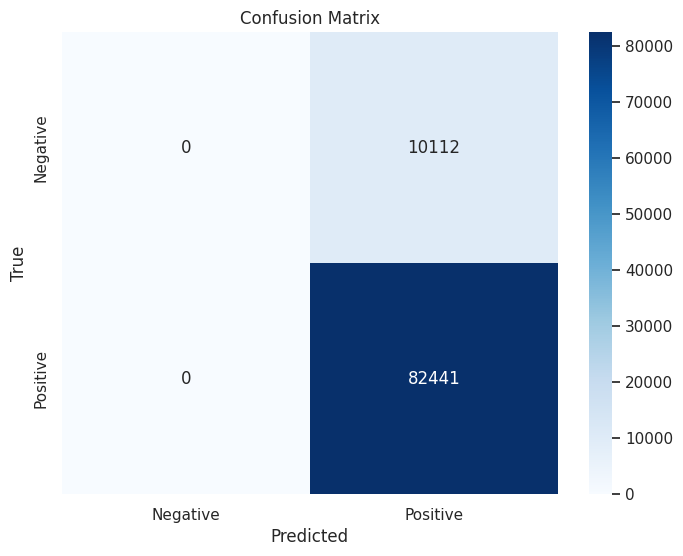

In [ ]:
# Assuming the pipeline has been fitted on the training data
y_pred = pipeline.predict(X_test)  # Predict on the test set

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
TN = cm[0][0]

In [ ]:
persentase_kesalahan_model = (FP / (TP+FP+TN+FN)) * 100

print(f'Persentase kesalahan prediksi resiko pinjaman yang menimbulkan kerugian: {persentase_kesalahan_model:.2f}%')

Persentase kesalahan prediksi resiko pinjaman yang menimbulkan kerugian: 10.93%


In [ ]:
persentase_kesalahan_model = (FN / (TP+FP+TN+FN)) * 100

print(f'Persentase kesalahan prediksi resiko pinjaman yang menimbulkan profit tidak maksimal: {persentase_kesalahan_model:.2f}%')

Persentase kesalahan prediksi resiko pinjaman yang menimbulkan profit tidak maksimal: 0.00%


In [ ]:
import pickle

# Assume 'pipeline' is your pre-trained LightGBM pipeline object
# Save the pipeline to a pickle file
with open('lightgbm_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

print("Pipeline saved to 'lightgbm_pipeline.pkl'")

Pipeline saved to 'lightgbm_pipeline.pkl'
